In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


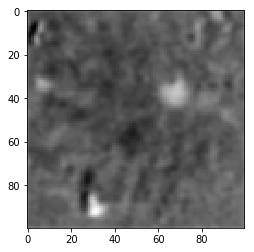

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'fullSess04' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 1000
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
dr = 0.4 #dropout rate
pre_pad_type = "SYMMETRIC"
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


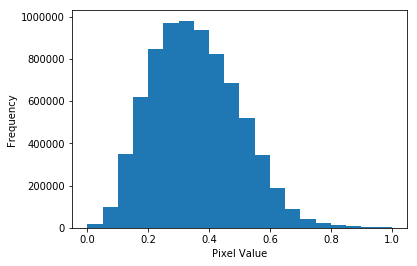

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


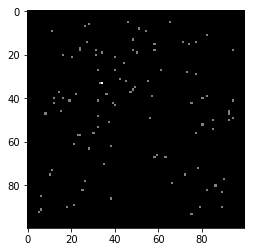

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def exp_pad(tensor_input, pre_pad_type ):
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    pad_output=tf.pad(tensor_input, paddings, pre_pad_type )
    return pad_output

    
    
def encoder(inps, img_size, pre_pad_type):
    
    #conv block1
    coord=exp_pad(inps, pre_pad_type)
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    act1=tf.keras.layers.ReLU()(coord1)
    pool1=MaxPooling2D((2, 2), padding='same')(act1)
    #conv block2
    
    coord3=exp_pad(pool1, pre_pad_type)

    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu')(coord3)
    pool2=MaxPooling2D((2, 2),padding='same')(conv1)
    
    #conv block3  
    
    coord5=exp_pad(pool2, pre_pad_type)
    x1 = Conv2D(64, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x01 = UpSampling2D(size=(2, 2),interpolation='bilinear')(x1)

    #conv block4
    x=exp_pad(x01, pre_pad_type)
    x2 = Conv2D(128, 3, padding = 'valid', activation = 'relu')(x)
    add1 = tf.keras.layers.Add()([x2, pool1])
    do = tf.keras.layers.Dropout(0.5)(add1)
    x2 = UpSampling2D(size=(2,2),interpolation='bilinear')(do)

    #conv block5
    x=exp_pad(x2, pre_pad_type)
    x03 = Conv2D(16, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(x)
    #add2 = tf.keras.layers.Add()([x03, act1])
    do1 = tf.keras.layers.Dropout(0.5)(x03)
    x=exp_pad(do1, pre_pad_type)
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid',activity_regularizer=l1(0.1))(x)
    return output



def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def de_conv02(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(coord01)
    f1 = Flatten()(conv01)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y
    
def gaussian_blur(img, kernel_size=3, sigma=0.01):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE, pre_pad_type))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        gaussian_blurr_input_images=gaussian_blur(inp_imgs)
        encoder_output = encoder_model(gaussian_blurr_input_images)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = bxent(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = bxent(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

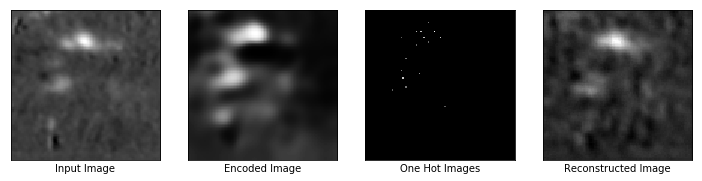

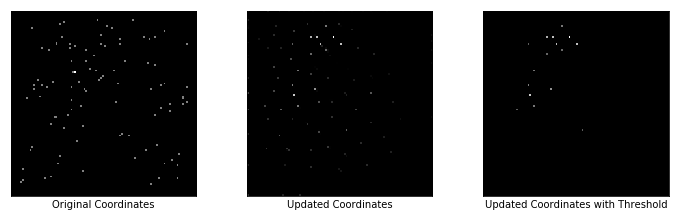

Epochs: 100, Session: 0
Reconstruction Loss: 0.0017413829918950796
Regularizer Loss: 33700.17578125, Total Loss: 33700.17578125
Encoder Loss: 4.133787631988525
Max Similarity scores: 0.873551607131958
Updated Coordinates: [[[0.        0.8358666]]]
Gradient global min:-0.0053607444278895855, max:0.005321621894836426
Gradient encoder min:-2.1956491470336914, max:1.1399749517440796
Gradient learnable coords min:-1.9039836843148805e-05, max:5.385260010370985e-05



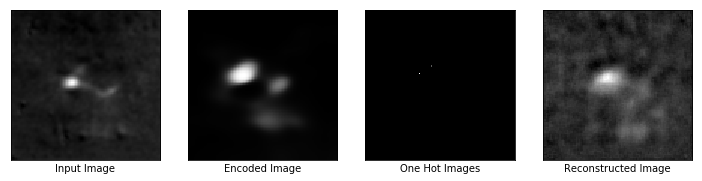

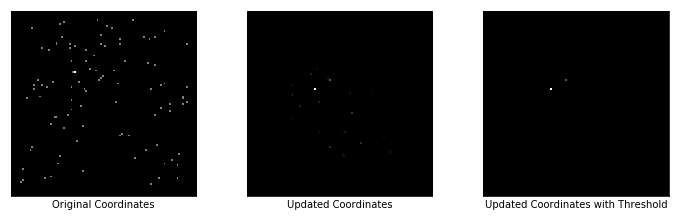

Epochs: 100, Session: 1
Reconstruction Loss: 0.0013841659529134631
Regularizer Loss: 22674.9921875, Total Loss: 22674.994140625
Encoder Loss: 0.8850189447402954
Max Similarity scores: 0.9361398816108704
Updated Coordinates: [[[0.       0.834577]]]
Gradient global min:-0.00011807192640844733, max:0.00036549975629895926
Gradient encoder min:-2.091843605041504, max:1.0528573989868164
Gradient learnable coords min:-5.21329320690711e-06, max:8.792988410277758e-06



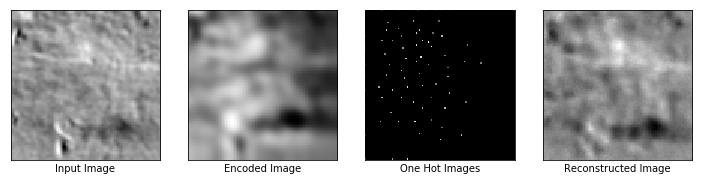

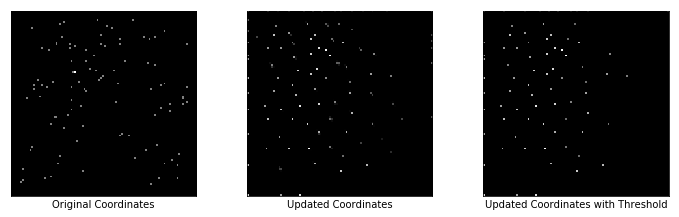

Epochs: 100, Session: 2
Reconstruction Loss: 0.0027554465923458338
Regularizer Loss: 44453.078125, Total Loss: 44453.08203125
Encoder Loss: 6.792314052581787
Max Similarity scores: 0.7799370288848877
Updated Coordinates: [[[0.         0.83712375]]]
Gradient global min:-0.0005282447673380375, max:0.0006353557691909373
Gradient encoder min:-1.5264017581939697, max:1.6928236484527588
Gradient learnable coords min:-1.5427278412971646e-05, max:1.0372407814429607e-05



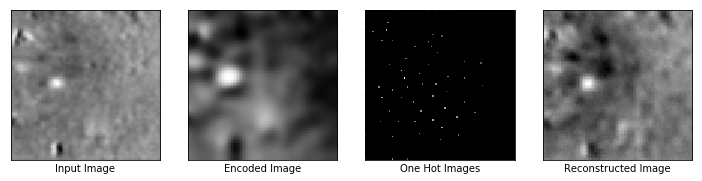

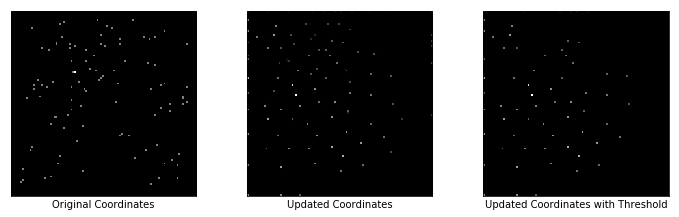

Epochs: 100, Session: 3
Reconstruction Loss: 0.0013529887655749917
Regularizer Loss: 37439.83984375, Total Loss: 37439.83984375
Encoder Loss: 5.278947830200195
Max Similarity scores: 0.9321560859680176
Updated Coordinates: [[[0.        0.8372855]]]
Gradient global min:-0.0003009742358699441, max:0.00041403601062484086
Gradient encoder min:-1.788960576057434, max:1.2323341369628906
Gradient learnable coords min:-9.936334208759945e-06, max:4.352904852567008e-06



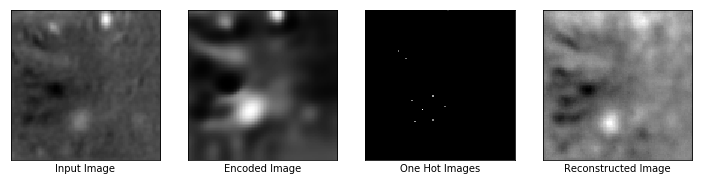

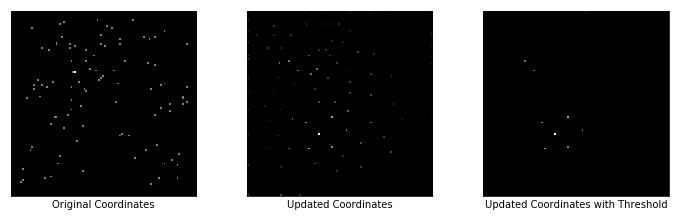

Epochs: 100, Session: 4
Reconstruction Loss: 0.001505633001215756
Regularizer Loss: 31413.091796875, Total Loss: 31413.09375
Encoder Loss: 3.485917329788208
Max Similarity scores: 0.6809812784194946
Updated Coordinates: [[[0.        0.8375712]]]
Gradient global min:-0.001398446736857295, max:0.000676891126204282
Gradient encoder min:-2.4923593997955322, max:1.105583906173706
Gradient learnable coords min:-1.1651667591650039e-05, max:1.32792110889568e-05



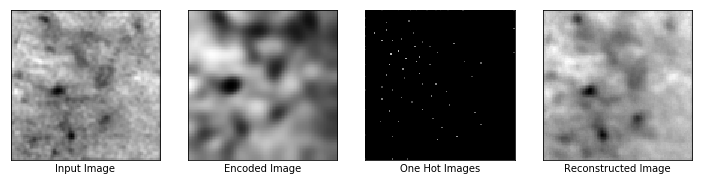

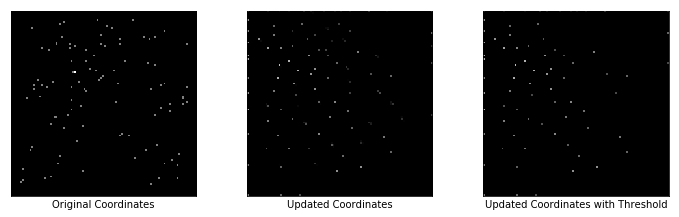

Epochs: 100, Session: 5
Reconstruction Loss: 0.0021143921185284853
Regularizer Loss: 42440.41015625, Total Loss: 42440.4140625
Encoder Loss: 6.10050106048584
Max Similarity scores: 0.8369709253311157
Updated Coordinates: [[[0.         0.83738744]]]
Gradient global min:-0.0010408402886241674, max:0.001126591581851244
Gradient encoder min:-1.5038373470306396, max:1.5557715892791748
Gradient learnable coords min:-1.0892255886574276e-05, max:4.697678832599195e-06



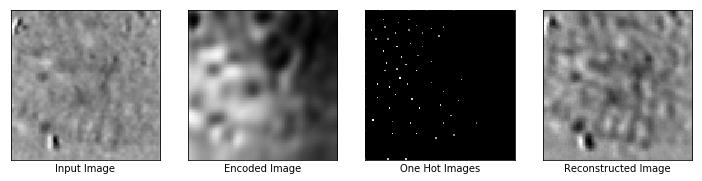

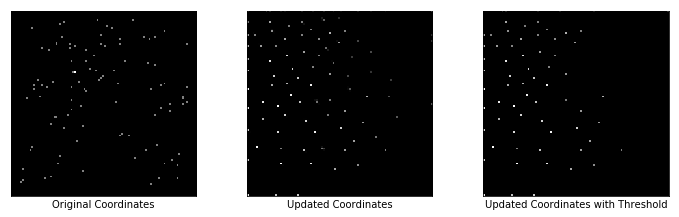

Epochs: 200, Session: 0
Reconstruction Loss: 0.0011611710069701076
Regularizer Loss: 49922.30859375, Total Loss: 49922.30859375
Encoder Loss: 3.4965813159942627
Max Similarity scores: 0.6618937849998474
Updated Coordinates: [[[0.         0.80788547]]]
Gradient global min:-0.00014253411791287363, max:9.171813144348562e-05
Gradient encoder min:-2.0218091011047363, max:1.020939826965332
Gradient learnable coords min:-4.428339161677286e-05, max:1.0705934073484968e-05



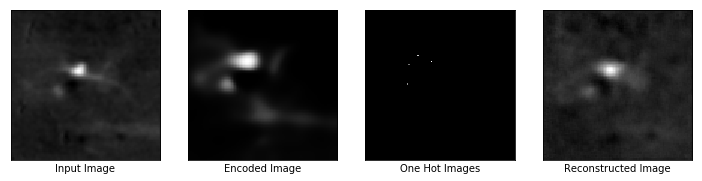

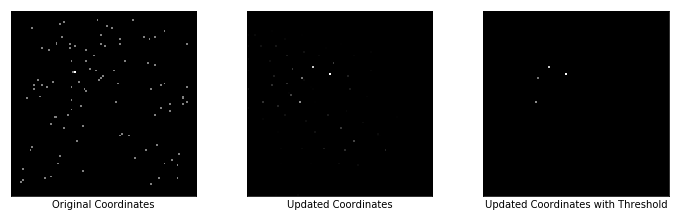

Epochs: 200, Session: 1
Reconstruction Loss: 0.0010826094076037407
Regularizer Loss: 37052.8671875, Total Loss: 37052.8671875
Encoder Loss: 0.8096804022789001
Max Similarity scores: 0.66233229637146
Updated Coordinates: [[[0.         0.80668724]]]
Gradient global min:-0.0002727823448367417, max:0.0004560600791592151
Gradient encoder min:-2.315124988555908, max:1.158727765083313
Gradient learnable coords min:-1.5902436643955298e-05, max:1.93294690689072e-05



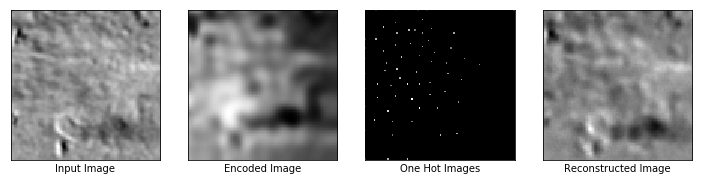

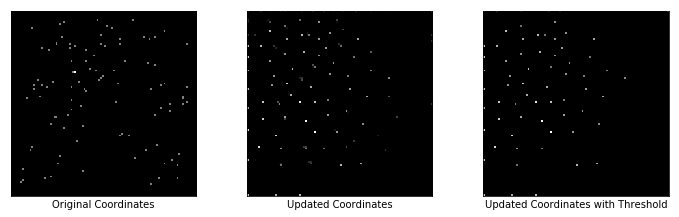

Epochs: 200, Session: 2
Reconstruction Loss: 0.0019384260522201657
Regularizer Loss: 63459.20703125, Total Loss: 63459.20703125
Encoder Loss: 5.72482967376709
Max Similarity scores: 0.6877164840698242
Updated Coordinates: [[[0.         0.80735075]]]
Gradient global min:-0.0003066216013394296, max:0.00023088337911758572
Gradient encoder min:-1.2417842149734497, max:1.3330093622207642
Gradient learnable coords min:-5.490715557243675e-05, max:2.482294075889513e-05



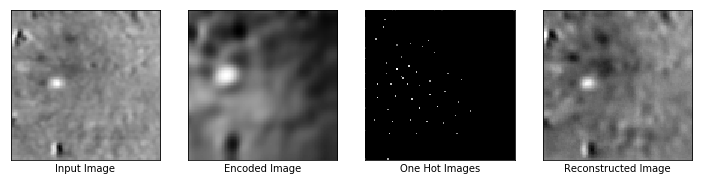

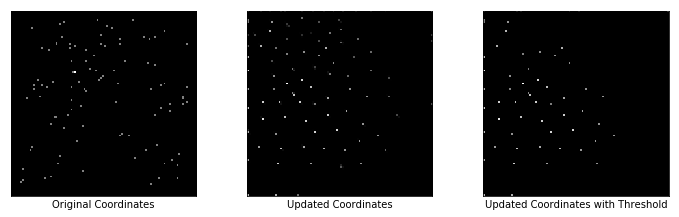

Epochs: 200, Session: 3
Reconstruction Loss: 0.0010551733430474997
Regularizer Loss: 54145.4921875, Total Loss: 54145.4921875
Encoder Loss: 4.4567646980285645
Max Similarity scores: 0.8540085554122925
Updated Coordinates: [[[0.         0.80575275]]]
Gradient global min:-0.002010888187214732, max:0.0012600794434547424
Gradient encoder min:-1.6037558317184448, max:0.9397519826889038
Gradient learnable coords min:-3.850272605632199e-06, max:1.1935029760934412e-05



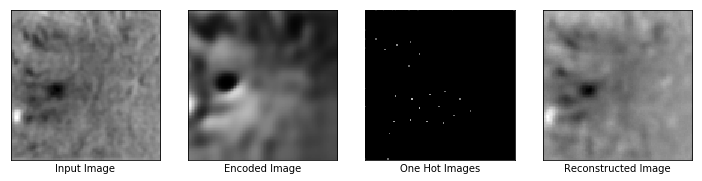

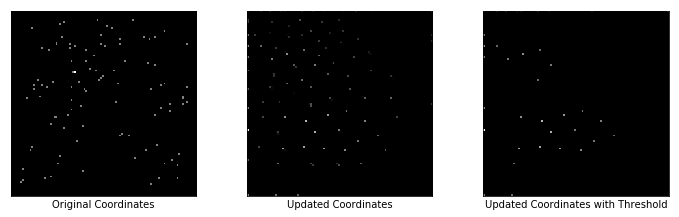

Epochs: 200, Session: 4
Reconstruction Loss: 0.0011283188359811902
Regularizer Loss: 46714.27734375, Total Loss: 46714.27734375
Encoder Loss: 2.924112558364868
Max Similarity scores: 0.7701219916343689
Updated Coordinates: [[[0.        0.8065196]]]
Gradient global min:-5.1104798330925405e-05, max:0.00026464532129466534
Gradient encoder min:-2.0654711723327637, max:0.9937494397163391
Gradient learnable coords min:-1.4667804862256162e-05, max:2.4253411538666114e-05



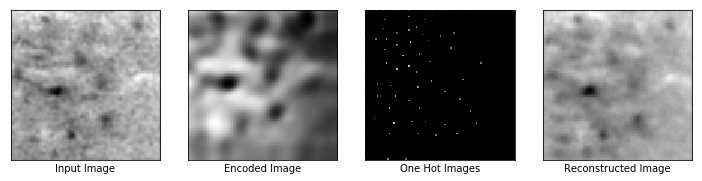

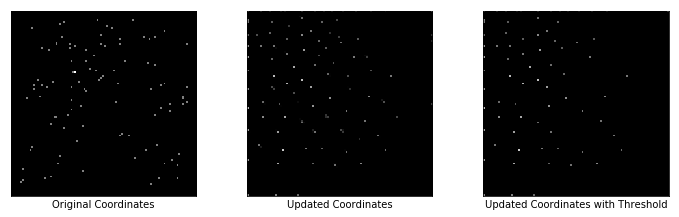

Epochs: 200, Session: 5
Reconstruction Loss: 0.002368006156757474
Regularizer Loss: 60676.65234375, Total Loss: 60676.65625
Encoder Loss: 5.221524238586426
Max Similarity scores: 0.7606946229934692
Updated Coordinates: [[[0.        0.8060649]]]
Gradient global min:-0.009173010475933552, max:0.005896043032407761
Gradient encoder min:-1.4265377521514893, max:1.1602493524551392
Gradient learnable coords min:-4.60434821434319e-05, max:4.146083301748149e-05



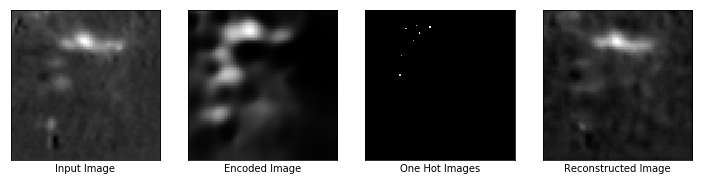

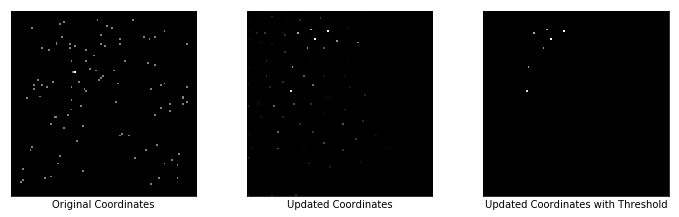

Epochs: 300, Session: 0
Reconstruction Loss: 0.00106415047775954
Regularizer Loss: 58567.3203125, Total Loss: 58567.3203125
Encoder Loss: 2.5570948123931885
Max Similarity scores: 0.5138595700263977
Updated Coordinates: [[[0.        0.7970088]]]
Gradient global min:-0.0004675423842854798, max:0.0003614371526055038
Gradient encoder min:-1.507524847984314, max:0.6007100939750671
Gradient learnable coords min:-7.649657163710799e-06, max:1.4418823411688209e-05



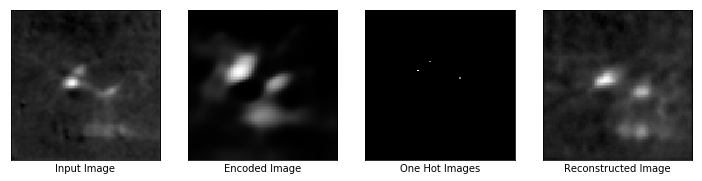

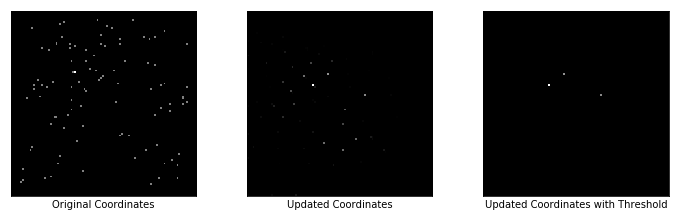

Epochs: 300, Session: 1
Reconstruction Loss: 0.0009145467774942517
Regularizer Loss: 46803.41015625, Total Loss: 46803.41015625
Encoder Loss: 0.6450980305671692
Max Similarity scores: 0.7266587018966675
Updated Coordinates: [[[0.        0.7949884]]]
Gradient global min:-0.0012515585403889418, max:0.000646771106403321
Gradient encoder min:-1.5552622079849243, max:0.6657013893127441
Gradient learnable coords min:-1.4026035387360025e-05, max:2.2798367353971116e-05



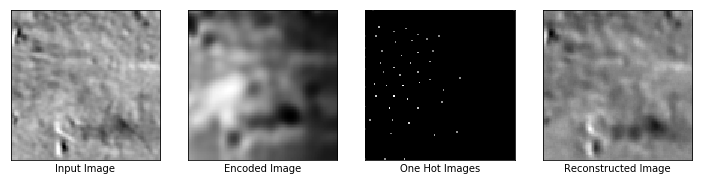

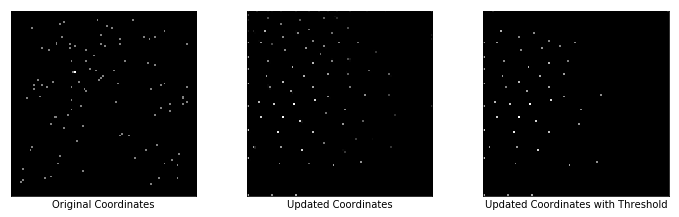

Epochs: 300, Session: 2
Reconstruction Loss: 0.001518620178103447
Regularizer Loss: 72094.4140625, Total Loss: 72094.4140625
Encoder Loss: 4.147374153137207
Max Similarity scores: 0.6201484799385071
Updated Coordinates: [[[0.         0.79530966]]]
Gradient global min:-0.0015481499722227454, max:0.002602064050734043
Gradient encoder min:-1.0166897773742676, max:1.1231602430343628
Gradient learnable coords min:-4.486122179514496e-06, max:1.40256124723237e-05



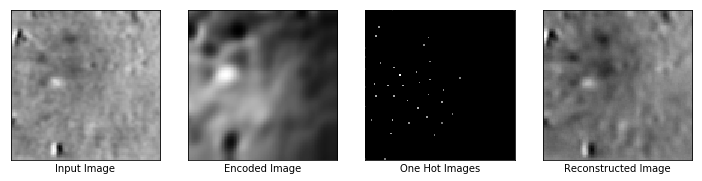

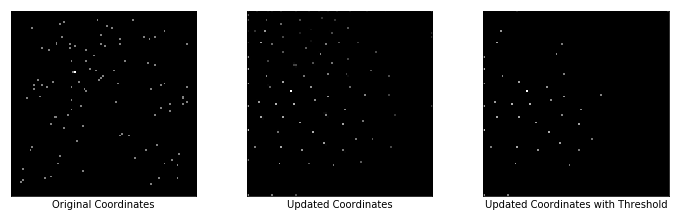

Epochs: 300, Session: 3
Reconstruction Loss: 0.0008867433643899858
Regularizer Loss: 62270.1015625, Total Loss: 62270.1015625
Encoder Loss: 3.2386014461517334
Max Similarity scores: 0.6611611247062683
Updated Coordinates: [[[0.        0.8064068]]]
Gradient global min:-0.004815950058400631, max:0.009650107473134995
Gradient encoder min:-1.1879477500915527, max:0.8210327625274658
Gradient learnable coords min:-3.5185184970032424e-06, max:5.873118880117545e-06



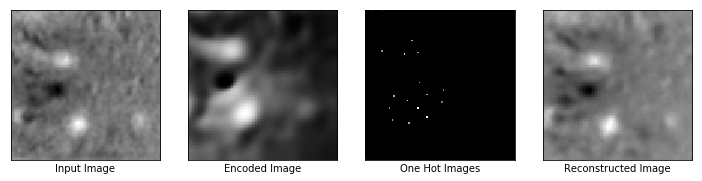

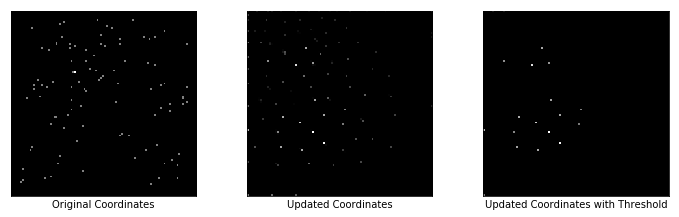

Epochs: 300, Session: 4
Reconstruction Loss: 0.001089850440621376
Regularizer Loss: 55545.265625, Total Loss: 55545.265625
Encoder Loss: 2.1660284996032715
Max Similarity scores: 0.6509595513343811
Updated Coordinates: [[[0.        0.8177157]]]
Gradient global min:-0.0016904145013540983, max:0.0022660240065306425
Gradient encoder min:-1.5614538192749023, max:0.6253347992897034
Gradient learnable coords min:-2.584457070042845e-05, max:1.3183236660552211e-05



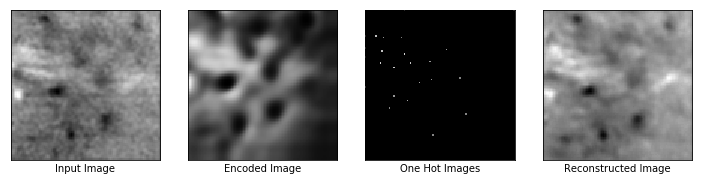

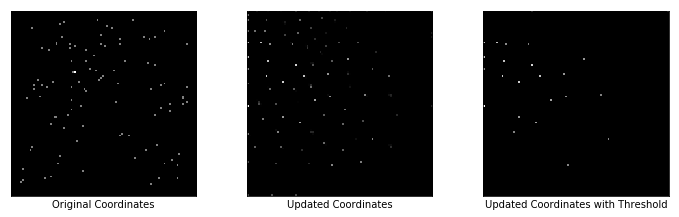

Epochs: 300, Session: 5
Reconstruction Loss: 0.0018318530637770891
Regularizer Loss: 69674.7578125, Total Loss: 69674.7578125
Encoder Loss: 3.7508864402770996
Max Similarity scores: 0.6136332750320435
Updated Coordinates: [[[0.        0.8159336]]]
Gradient global min:-0.0010075325844809413, max:0.0016644200077280402
Gradient encoder min:-1.1208927631378174, max:1.011151671409607
Gradient learnable coords min:-2.871962533390615e-05, max:2.5605366317904554e-05



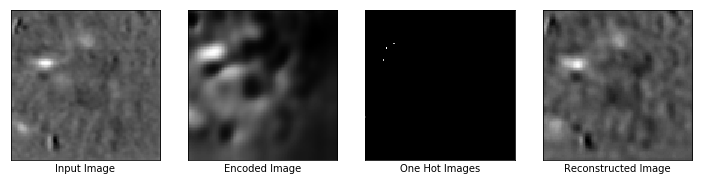

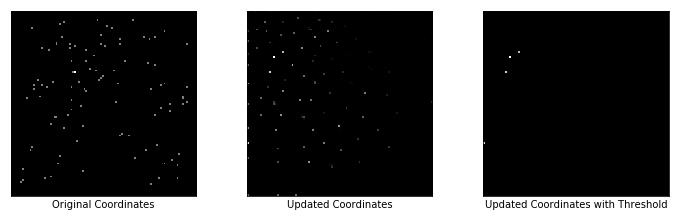

Epochs: 400, Session: 0
Reconstruction Loss: 0.000889170914888382
Regularizer Loss: 98921.4609375, Total Loss: 98921.4609375
Encoder Loss: 2.1005806922912598
Max Similarity scores: 0.45095065236091614
Updated Coordinates: [[[0.        0.7969904]]]
Gradient global min:-0.0035993889905512333, max:0.0060399798676371574
Gradient encoder min:-1.1696784496307373, max:0.5249069333076477
Gradient learnable coords min:-4.114090188522823e-05, max:2.8789932912332006e-05



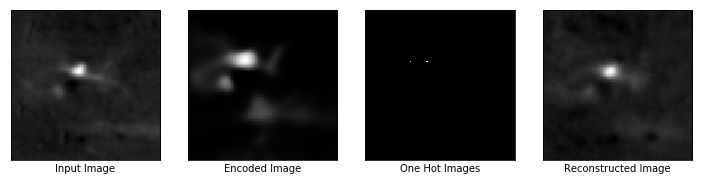

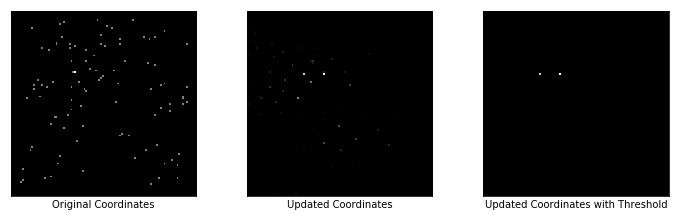

Epochs: 400, Session: 1
Reconstruction Loss: 0.0008764173253439367
Regularizer Loss: 81808.96875, Total Loss: 81808.96875
Encoder Loss: 0.5630648732185364
Max Similarity scores: 0.5378719568252563
Updated Coordinates: [[[0.        0.7964369]]]
Gradient global min:-0.00038917423808015883, max:0.000575163634493947
Gradient encoder min:-1.3911198377609253, max:0.5819277763366699
Gradient learnable coords min:-1.683281698205974e-05, max:1.2734099072986282e-05



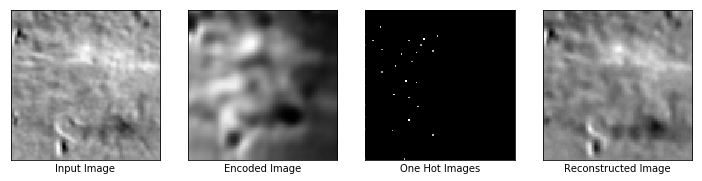

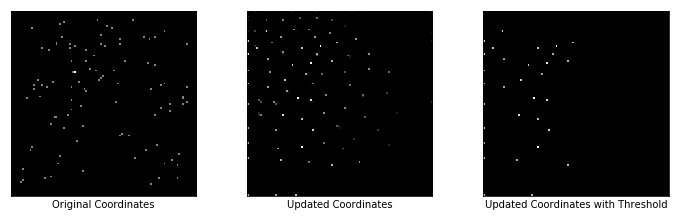

Epochs: 400, Session: 2
Reconstruction Loss: 0.0013278478290885687
Regularizer Loss: 117072.375, Total Loss: 117072.375
Encoder Loss: 3.3703501224517822
Max Similarity scores: 0.5069635510444641
Updated Coordinates: [[[0.         0.79502964]]]
Gradient global min:-0.01146272849291563, max:0.024580378085374832
Gradient encoder min:-0.8383201360702515, max:0.7984274625778198
Gradient learnable coords min:-3.607053804444149e-05, max:2.2513462681672536e-05



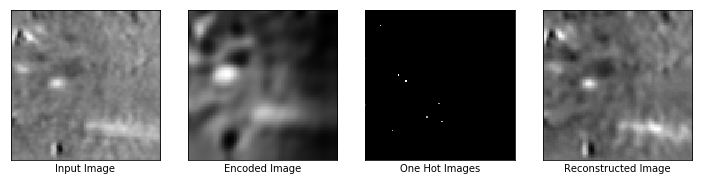

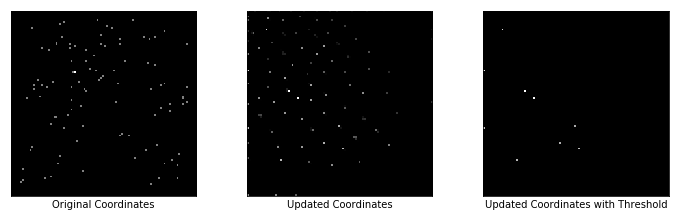

Epochs: 400, Session: 3
Reconstruction Loss: 0.0008802164229564369
Regularizer Loss: 103744.3359375, Total Loss: 103744.3359375
Encoder Loss: 2.6155502796173096
Max Similarity scores: 0.5712571740150452
Updated Coordinates: [[[0.        0.7947953]]]
Gradient global min:-0.018658427521586418, max:0.02331700176000595
Gradient encoder min:-0.8944491744041443, max:0.5756543278694153
Gradient learnable coords min:-1.773811709426809e-05, max:2.285513619426638e-05



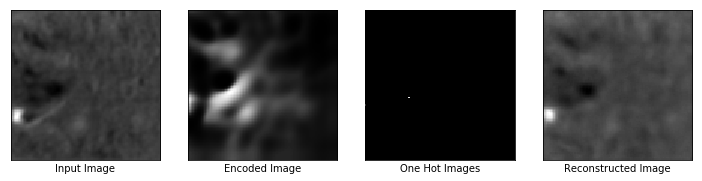

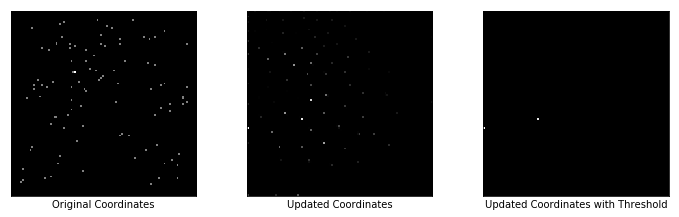

Epochs: 400, Session: 4
Reconstruction Loss: 0.0009517757571302354
Regularizer Loss: 94924.6875, Total Loss: 94924.6875
Encoder Loss: 1.752029299736023
Max Similarity scores: 0.36123591661453247
Updated Coordinates: [[[0.       0.795383]]]
Gradient global min:-0.01821492612361908, max:0.009021331556141376
Gradient encoder min:-1.1441460847854614, max:0.45676684379577637
Gradient learnable coords min:-1.289443298446713e-05, max:5.858322765561752e-06



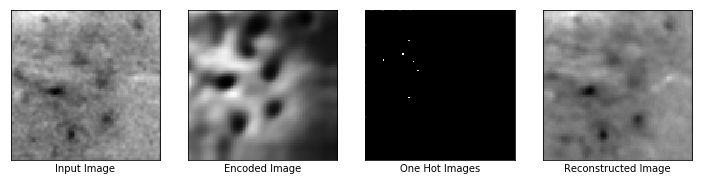

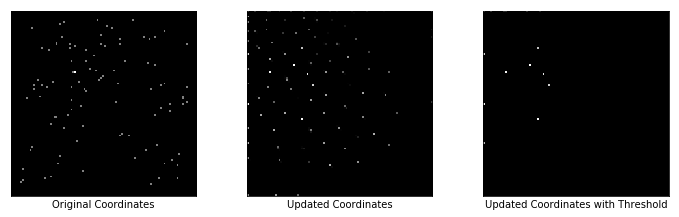

Epochs: 400, Session: 5
Reconstruction Loss: 0.0016031826380640268
Regularizer Loss: 114543.359375, Total Loss: 114543.359375
Encoder Loss: 3.0106825828552246
Max Similarity scores: 0.4253394305706024
Updated Coordinates: [[[0.        0.7950428]]]
Gradient global min:-0.0028997110202908516, max:0.001995221944525838
Gradient encoder min:-0.825785219669342, max:0.6849544048309326
Gradient learnable coords min:-1.5227273252094164e-05, max:2.085432606691029e-05



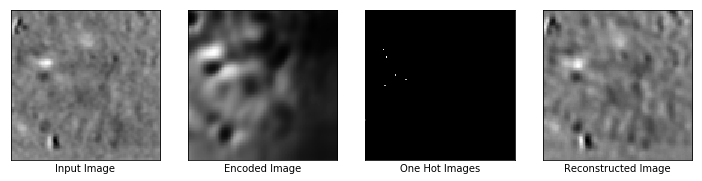

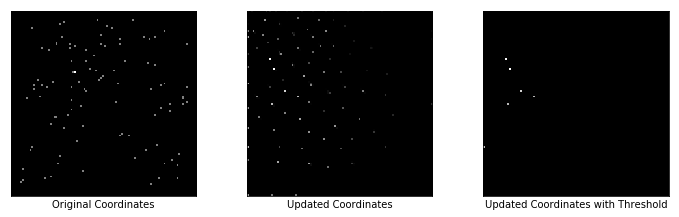

Epochs: 500, Session: 0
Reconstruction Loss: 0.000976608949713409
Regularizer Loss: 136878.796875, Total Loss: 136878.796875
Encoder Loss: 1.6420611143112183
Max Similarity scores: 0.4327894151210785
Updated Coordinates: [[[0.        0.8065574]]]
Gradient global min:-0.0026981746777892113, max:0.0018585141515359282
Gradient encoder min:-0.8079289197921753, max:0.49860188364982605
Gradient learnable coords min:-2.307699469383806e-05, max:2.017633232753724e-05



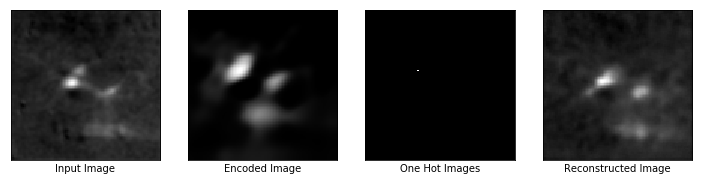

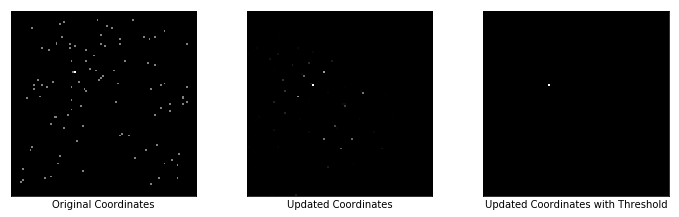

Epochs: 500, Session: 1
Reconstruction Loss: 0.000817318563349545
Regularizer Loss: 118867.5390625, Total Loss: 118867.5390625
Encoder Loss: 0.41570499539375305
Max Similarity scores: 0.5480133295059204
Updated Coordinates: [[[0.         0.81035584]]]
Gradient global min:-0.0033460776321589947, max:0.001632357481867075
Gradient encoder min:-0.9638814330101013, max:0.455903559923172
Gradient learnable coords min:-9.008232154883444e-06, max:3.512124021654017e-05



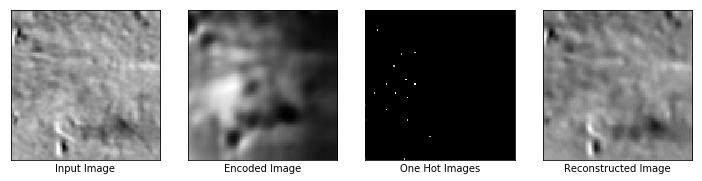

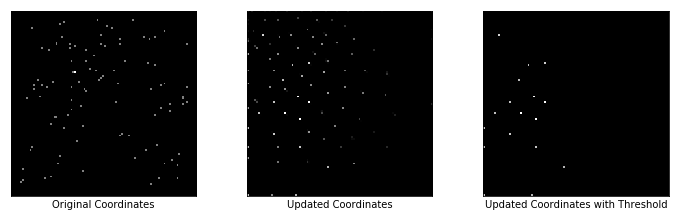

Epochs: 500, Session: 2
Reconstruction Loss: 0.0014773033326491714
Regularizer Loss: 157510.328125, Total Loss: 157510.328125
Encoder Loss: 2.595559597015381
Max Similarity scores: 0.4465268552303314
Updated Coordinates: [[[0.         0.80126727]]]
Gradient global min:-0.005123604089021683, max:0.009053272195160389
Gradient encoder min:-0.6927563548088074, max:0.7004982233047485
Gradient learnable coords min:-3.095330612268299e-05, max:7.096957415342331e-05



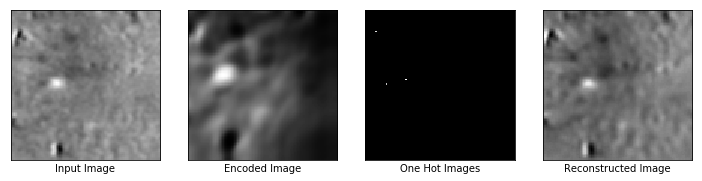

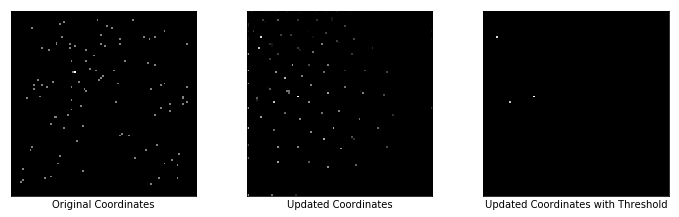

Epochs: 500, Session: 3
Reconstruction Loss: 0.0010257601970806718
Regularizer Loss: 141354.328125, Total Loss: 141354.328125
Encoder Loss: 1.9499303102493286
Max Similarity scores: 0.5214160680770874
Updated Coordinates: [[[0.        0.7972494]]]
Gradient global min:-0.002734250156208873, max:0.003874772461131215
Gradient encoder min:-0.6760635375976562, max:0.5009270310401917
Gradient learnable coords min:-4.099458965356462e-05, max:2.1056297555333003e-05



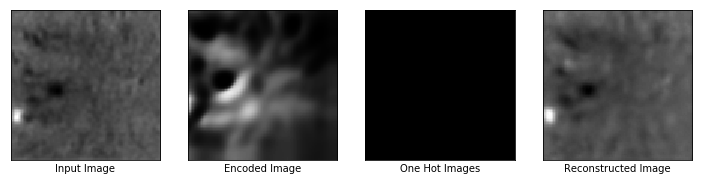

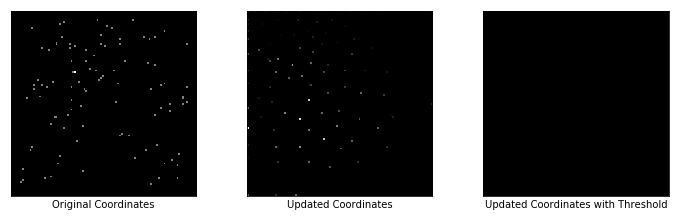

Epochs: 500, Session: 4
Reconstruction Loss: 0.0009836447425186634
Regularizer Loss: 131623.703125, Total Loss: 131623.703125
Encoder Loss: 1.3088254928588867
Max Similarity scores: 0.29176658391952515
Updated Coordinates: [[[0.        0.7940774]]]
Gradient global min:-0.008082510903477669, max:0.005485480185598135
Gradient encoder min:-0.8253626823425293, max:0.3897624611854553
Gradient learnable coords min:-8.880466339178383e-06, max:5.68579798709834e-06



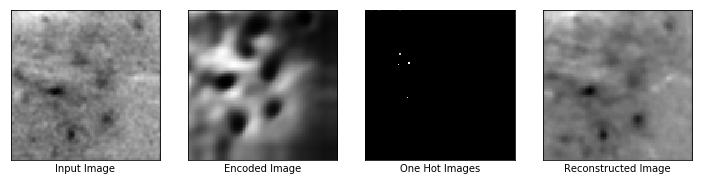

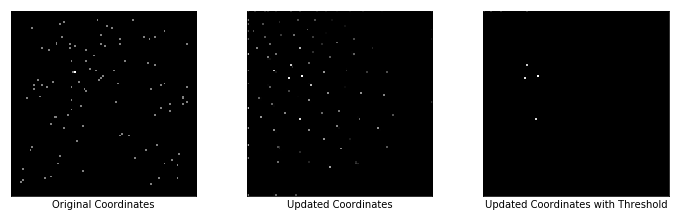

Epochs: 500, Session: 5
Reconstruction Loss: 0.001779016456566751
Regularizer Loss: 153117.625, Total Loss: 153117.625
Encoder Loss: 2.328953742980957
Max Similarity scores: 0.38343632221221924
Updated Coordinates: [[[0.        0.7958769]]]
Gradient global min:-0.012442799285054207, max:0.016584204509854317
Gradient encoder min:-0.6464323997497559, max:0.647071123123169
Gradient learnable coords min:-1.0584147275949363e-05, max:2.1051882868050598e-05



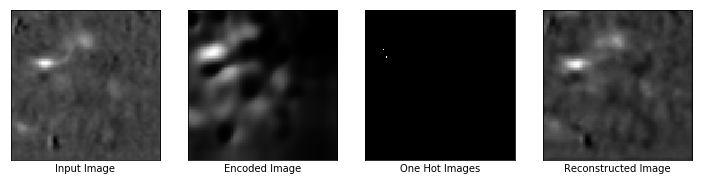

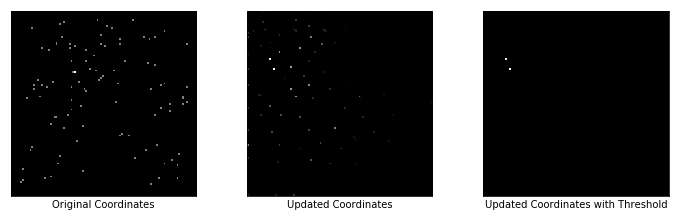

Epochs: 600, Session: 0
Reconstruction Loss: 0.0008565963944420218
Regularizer Loss: 150471.953125, Total Loss: 150471.953125
Encoder Loss: 1.4131109714508057
Max Similarity scores: 0.37253257632255554
Updated Coordinates: [[[0.         0.79553956]]]
Gradient global min:-0.0014291881816461682, max:0.0018865128513425589
Gradient encoder min:-0.5871659517288208, max:0.45789051055908203
Gradient learnable coords min:-1.0592196304060053e-05, max:1.661757232795935e-05



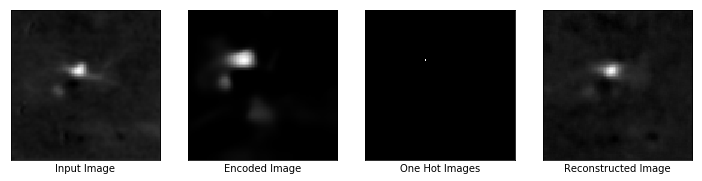

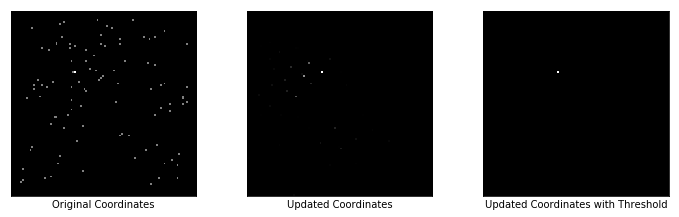

Epochs: 600, Session: 1
Reconstruction Loss: 0.0007469014381058514
Regularizer Loss: 132802.296875, Total Loss: 132802.296875
Encoder Loss: 0.3489021956920624
Max Similarity scores: 0.4247395396232605
Updated Coordinates: [[[0.         0.79472303]]]
Gradient global min:-0.00023649897775612772, max:0.00042222547926940024
Gradient encoder min:-0.6651722192764282, max:0.3502988815307617
Gradient learnable coords min:-9.60996749199694e-06, max:3.9092934457585216e-05



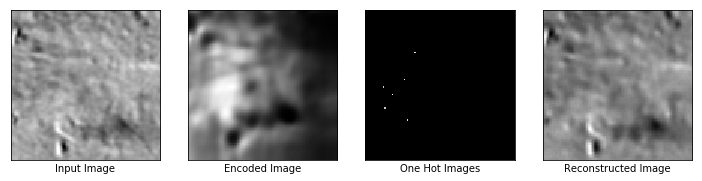

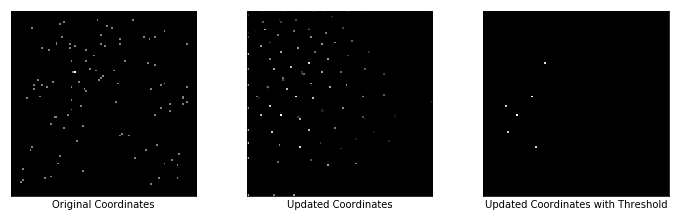

Epochs: 600, Session: 2
Reconstruction Loss: 0.0011973280925303698
Regularizer Loss: 170979.265625, Total Loss: 170979.265625
Encoder Loss: 2.352870464324951
Max Similarity scores: 0.3981863558292389
Updated Coordinates: [[[0.         0.79633576]]]
Gradient global min:-0.002449906198307872, max:0.003930356353521347
Gradient encoder min:-0.6736229658126831, max:0.7587344646453857
Gradient learnable coords min:-1.295198035222711e-05, max:1.594036257301923e-05



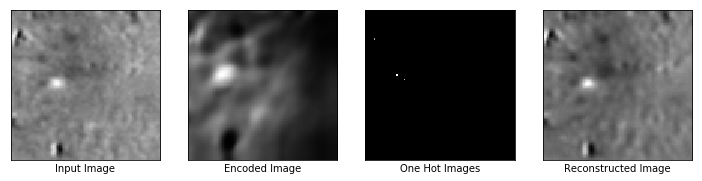

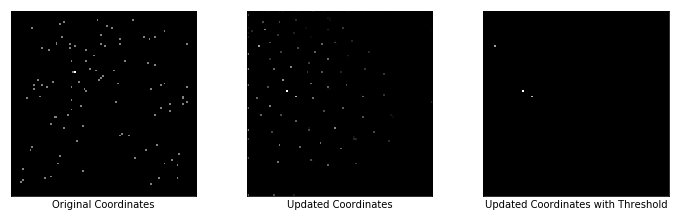

Epochs: 600, Session: 3
Reconstruction Loss: 0.0007151743629947305
Regularizer Loss: 155841.640625, Total Loss: 155841.640625
Encoder Loss: 1.7785589694976807
Max Similarity scores: 0.5145080089569092
Updated Coordinates: [[[0.         0.79483974]]]
Gradient global min:-0.00037513376446440816, max:0.0005699074827134609
Gradient encoder min:-0.4837120771408081, max:0.5348434448242188
Gradient learnable coords min:-1.0906309398706071e-05, max:9.277364370063879e-06



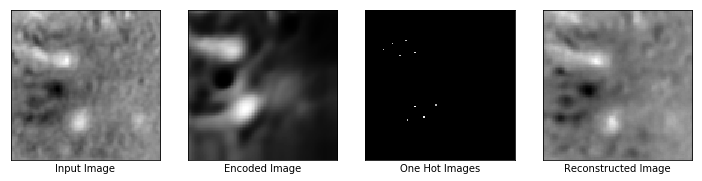

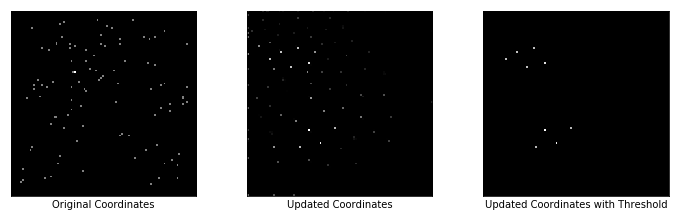

Epochs: 600, Session: 4
Reconstruction Loss: 0.0008587123593315482
Regularizer Loss: 145412.75, Total Loss: 145412.75
Encoder Loss: 1.153485894203186
Max Similarity scores: 0.4557701647281647
Updated Coordinates: [[[0.         0.79599845]]]
Gradient global min:-0.0004775428678840399, max:0.0002506951568648219
Gradient encoder min:-0.597438395023346, max:0.31938472390174866
Gradient learnable coords min:-9.553549898555502e-05, max:1.9261653505964205e-05



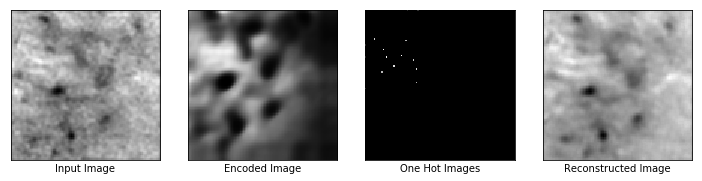

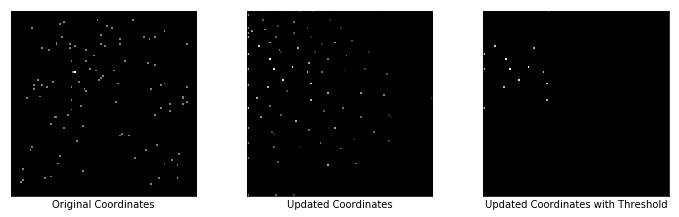

Epochs: 600, Session: 5
Reconstruction Loss: 0.0018470791401341558
Regularizer Loss: 166422.640625, Total Loss: 166422.640625
Encoder Loss: 2.202934741973877
Max Similarity scores: 0.44289979338645935
Updated Coordinates: [[[0.         0.79723245]]]
Gradient global min:-0.004509337712079287, max:0.004713152535259724
Gradient encoder min:-0.6382563710212708, max:0.6866384148597717
Gradient learnable coords min:-2.7195752409170382e-05, max:8.004424307728186e-05



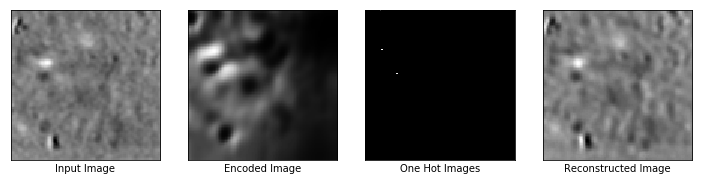

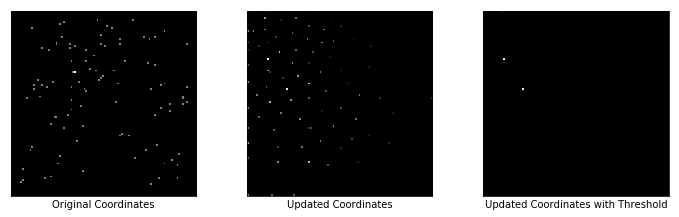

Epochs: 700, Session: 0
Reconstruction Loss: 0.0007260580314323306
Regularizer Loss: 190691.765625, Total Loss: 190691.765625
Encoder Loss: 1.2575119733810425
Max Similarity scores: 0.3702426850795746
Updated Coordinates: [[[0.         0.79542154]]]
Gradient global min:-0.0002124551683664322, max:6.976512668188661e-05
Gradient encoder min:-0.4080228805541992, max:0.40994369983673096
Gradient learnable coords min:-3.1805109756533056e-05, max:3.507836299831979e-05



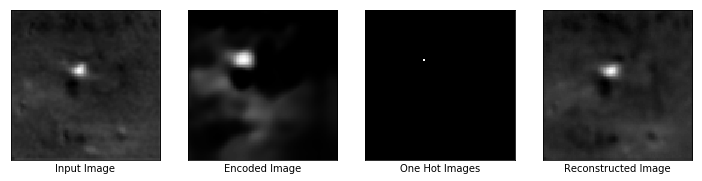

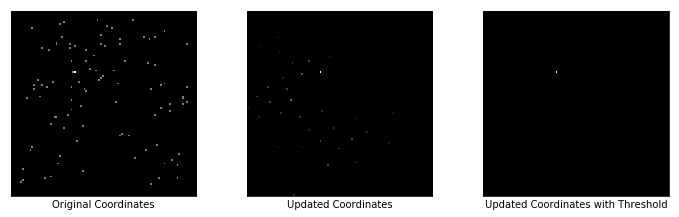

Epochs: 700, Session: 1
Reconstruction Loss: 0.0007013497524894774
Regularizer Loss: 163898.125, Total Loss: 163898.125
Encoder Loss: 0.32752934098243713
Max Similarity scores: 0.3830331861972809
Updated Coordinates: [[[0.         0.79505336]]]
Gradient global min:-0.001108937431126833, max:0.0007667505415156484
Gradient encoder min:-0.501291811466217, max:0.3162176012992859
Gradient learnable coords min:-3.5273403682367643e-06, max:2.8099444534746e-05



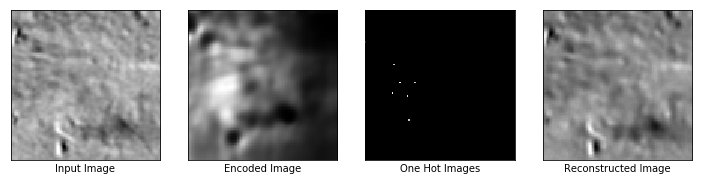

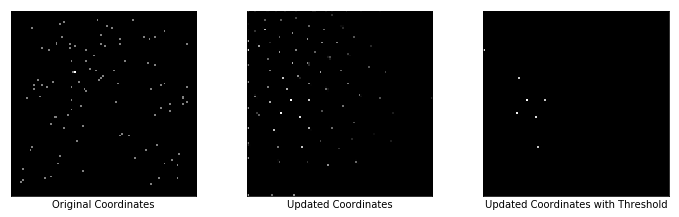

Epochs: 700, Session: 2
Reconstruction Loss: 0.0010897227330133319
Regularizer Loss: 216883.4375, Total Loss: 216883.4375
Encoder Loss: 2.1315672397613525
Max Similarity scores: 0.3977872133255005
Updated Coordinates: [[[0.        0.7967727]]]
Gradient global min:-0.0029286849312484264, max:0.0043507833033800125
Gradient encoder min:-0.6677451729774475, max:0.6988264322280884
Gradient learnable coords min:-2.574767859186977e-05, max:8.243016964115668e-06



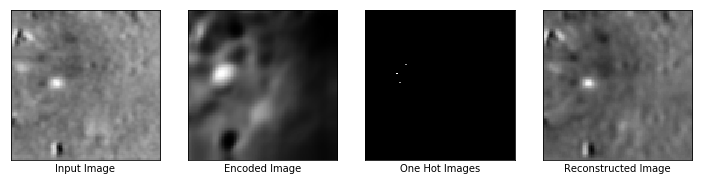

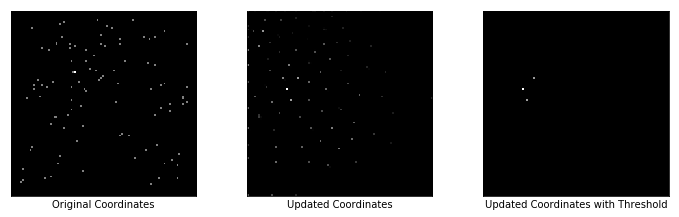

Epochs: 700, Session: 3
Reconstruction Loss: 0.0007140639354474843
Regularizer Loss: 197595.984375, Total Loss: 197595.984375
Encoder Loss: 1.616878628730774
Max Similarity scores: 0.5092378258705139
Updated Coordinates: [[[0.         0.79726225]]]
Gradient global min:-0.0008574020466767251, max:0.0008242815965786576
Gradient encoder min:-0.415418803691864, max:0.49507859349250793
Gradient learnable coords min:-1.0980489605572075e-05, max:8.024081580515485e-06



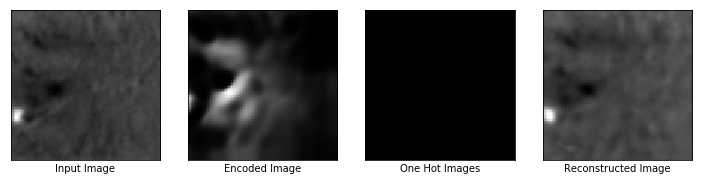

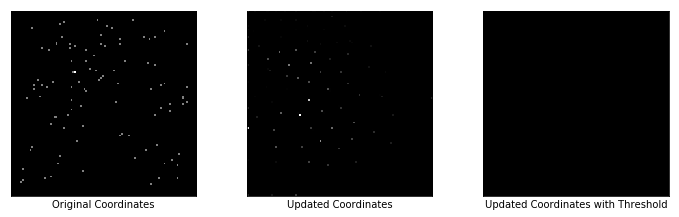

Epochs: 700, Session: 4
Reconstruction Loss: 0.0008913877536542714
Regularizer Loss: 183847.328125, Total Loss: 183847.328125
Encoder Loss: 1.010522484779358
Max Similarity scores: 0.23026520013809204
Updated Coordinates: [[[0.      0.80447]]]
Gradient global min:-0.00040483009070158005, max:0.0008477852097712457
Gradient encoder min:-0.4272952377796173, max:0.3014727532863617
Gradient learnable coords min:-5.5722530305502005e-06, max:1.983903757718508e-06



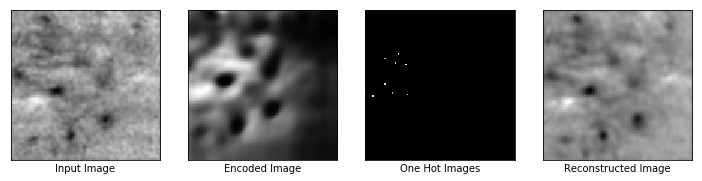

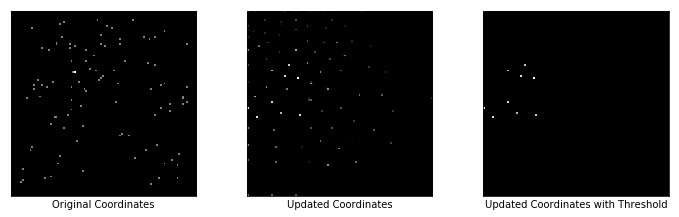

Epochs: 700, Session: 5
Reconstruction Loss: 0.001530997222289443
Regularizer Loss: 210725.09375, Total Loss: 210725.09375
Encoder Loss: 1.9050387144088745
Max Similarity scores: 0.4352492392063141
Updated Coordinates: [[[0.        0.8056903]]]
Gradient global min:-0.0005202624597586691, max:0.00031361813307739794
Gradient encoder min:-0.5793444514274597, max:0.6024174094200134
Gradient learnable coords min:-5.239678648649715e-05, max:7.644266588613391e-05



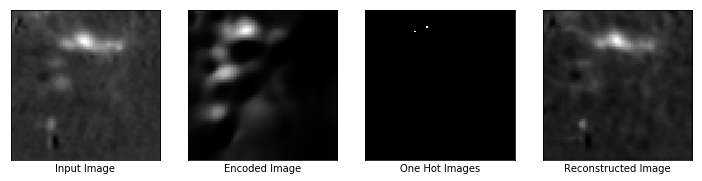

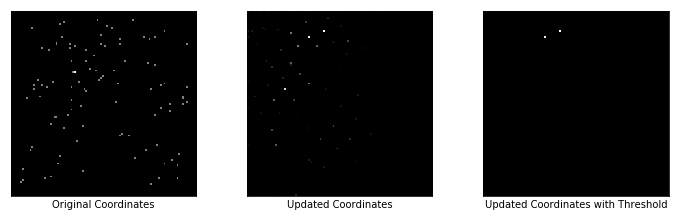

Epochs: 800, Session: 0
Reconstruction Loss: 0.0008202833123505116
Regularizer Loss: 211764.078125, Total Loss: 211764.078125
Encoder Loss: 1.2542662620544434
Max Similarity scores: 0.3439865708351135
Updated Coordinates: [[[0.        0.8073067]]]
Gradient global min:-0.001223392435349524, max:0.001400606706738472
Gradient encoder min:-0.41800302267074585, max:0.4748424291610718
Gradient learnable coords min:-6.030428994563408e-05, max:1.6043126379372552e-05



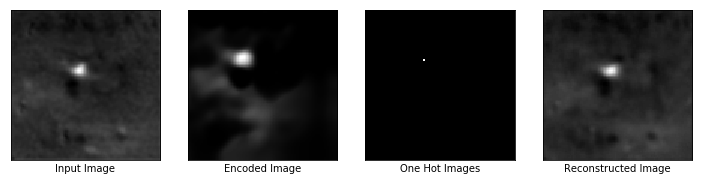

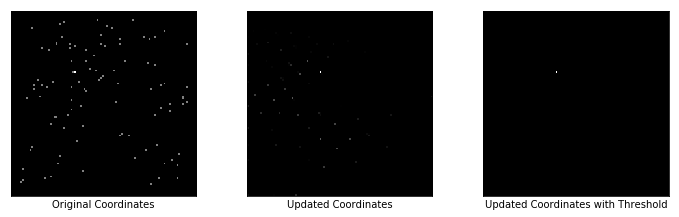

Epochs: 800, Session: 1
Reconstruction Loss: 0.0006237622001208365
Regularizer Loss: 182223.0, Total Loss: 182223.0
Encoder Loss: 0.28445613384246826
Max Similarity scores: 0.3513880968093872
Updated Coordinates: [[[0.        0.8062227]]]
Gradient global min:-0.0005525309825316072, max:0.0006868690834380686
Gradient encoder min:-0.3947683572769165, max:0.2140585035085678
Gradient learnable coords min:-6.7041360125585925e-06, max:2.6013312890427187e-06



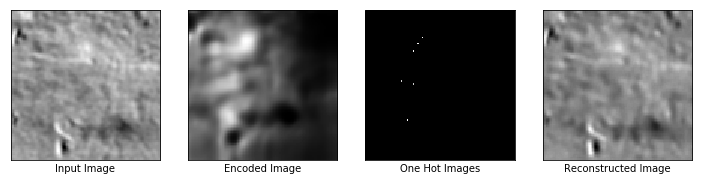

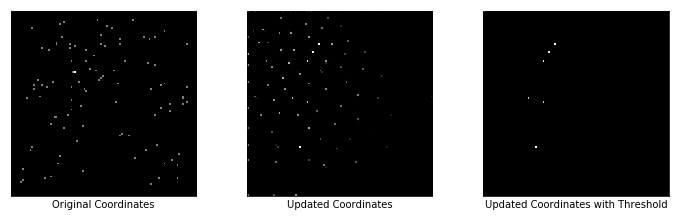

Epochs: 800, Session: 2
Reconstruction Loss: 0.0013665113365277648
Regularizer Loss: 239384.28125, Total Loss: 239384.28125
Encoder Loss: 2.0790445804595947
Max Similarity scores: 0.4270124137401581
Updated Coordinates: [[[0.         0.80642956]]]
Gradient global min:-0.0013951824512332678, max:0.0023855166509747505
Gradient encoder min:-0.7629062533378601, max:0.6568207740783691
Gradient learnable coords min:-4.0591963625047356e-05, max:5.078075992059894e-05



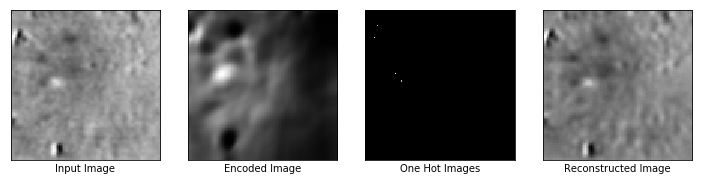

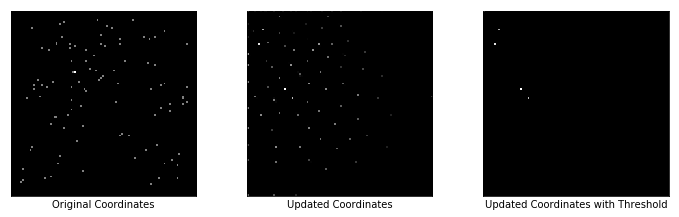

Epochs: 800, Session: 3
Reconstruction Loss: 0.001089874072931707
Regularizer Loss: 219476.53125, Total Loss: 219476.53125
Encoder Loss: 1.6434434652328491
Max Similarity scores: 0.48891234397888184
Updated Coordinates: [[[0.        0.8047091]]]
Gradient global min:-0.020116036757826805, max:0.013564984314143658
Gradient encoder min:-0.5041409134864807, max:0.5366179347038269
Gradient learnable coords min:-5.103384319227189e-05, max:8.46957991598174e-05



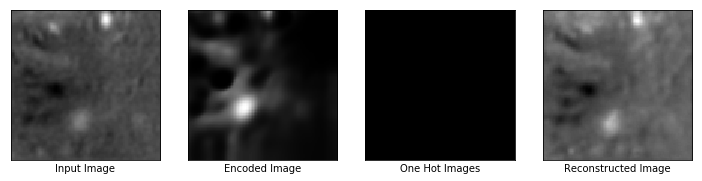

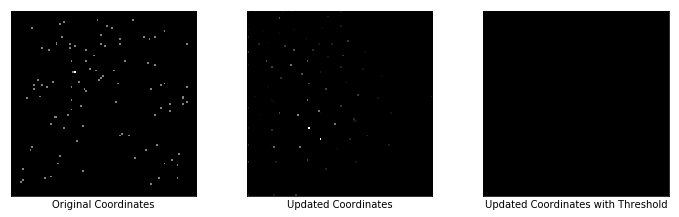

Epochs: 800, Session: 4
Reconstruction Loss: 0.0008467209991067648
Regularizer Loss: 204402.625, Total Loss: 204402.625
Encoder Loss: 1.00028657913208
Max Similarity scores: 0.30773401260375977
Updated Coordinates: [[[0.         0.82058084]]]
Gradient global min:-0.0005873912014067173, max:0.00033846593578346074
Gradient encoder min:-0.3330400884151459, max:0.3128410577774048
Gradient learnable coords min:-6.648364887951175e-06, max:1.672848520684056e-05



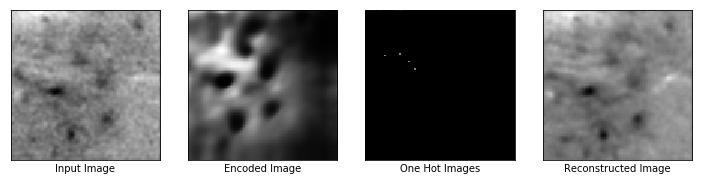

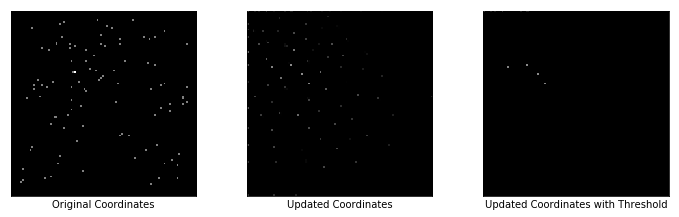

Epochs: 800, Session: 5
Reconstruction Loss: 0.0016536354087293148
Regularizer Loss: 232879.078125, Total Loss: 232879.078125
Encoder Loss: 1.9079313278198242
Max Similarity scores: 0.3929224908351898
Updated Coordinates: [[[0.        0.8184076]]]
Gradient global min:-0.014385911636054516, max:0.007900192402303219
Gradient encoder min:-0.6992687582969666, max:0.6164605617523193
Gradient learnable coords min:-4.999530574423261e-05, max:8.919677202356979e-05



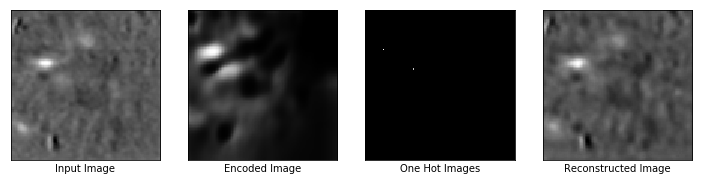

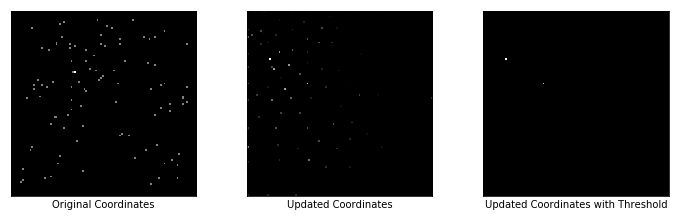

Epochs: 900, Session: 0
Reconstruction Loss: 0.0008995899115689099
Regularizer Loss: 203470.03125, Total Loss: 203470.03125
Encoder Loss: 1.0956448316574097
Max Similarity scores: 0.4106124937534332
Updated Coordinates: [[[0.        0.8202773]]]
Gradient global min:-0.007142229937016964, max:0.004627223592251539
Gradient encoder min:-0.4271174967288971, max:0.49548661708831787
Gradient learnable coords min:-0.00012080669694114476, max:2.6120884285774082e-05



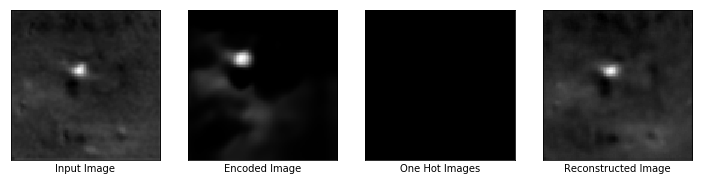

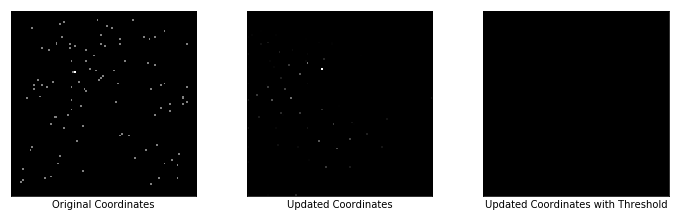

Epochs: 900, Session: 1
Reconstruction Loss: 0.0006991085829213262
Regularizer Loss: 178090.8125, Total Loss: 178090.8125
Encoder Loss: 0.20111460983753204
Max Similarity scores: 0.26732227206230164
Updated Coordinates: [[[0.        0.8183676]]]
Gradient global min:-0.0005883373669348657, max:0.0006670938455499709
Gradient encoder min:-0.2663576006889343, max:0.12719514966011047
Gradient learnable coords min:-3.145108621538384e-06, max:2.9966977308504283e-06



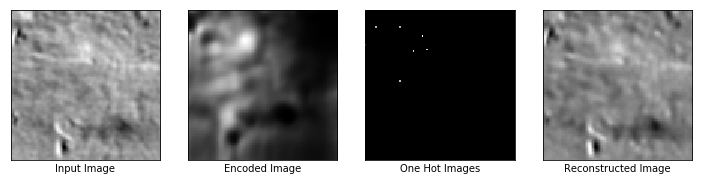

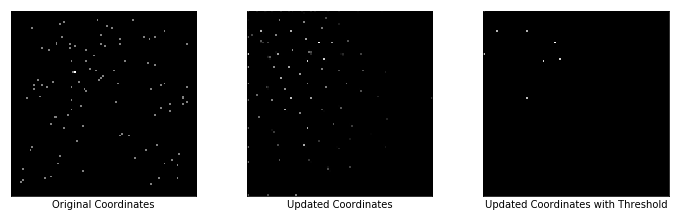

Epochs: 900, Session: 2
Reconstruction Loss: 0.0011884757550433278
Regularizer Loss: 226962.328125, Total Loss: 226962.328125
Encoder Loss: 1.9774316549301147
Max Similarity scores: 0.43862301111221313
Updated Coordinates: [[[0.        0.8174617]]]
Gradient global min:-0.0009187766700051725, max:0.0015465851174667478
Gradient encoder min:-0.8501600027084351, max:0.7330610752105713
Gradient learnable coords min:-2.597538878035266e-05, max:9.130348917096853e-05



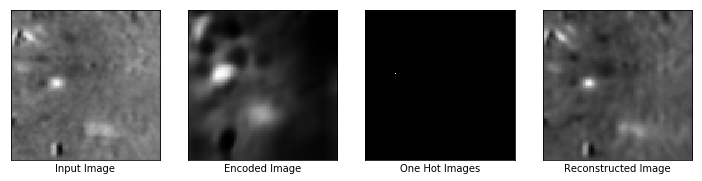

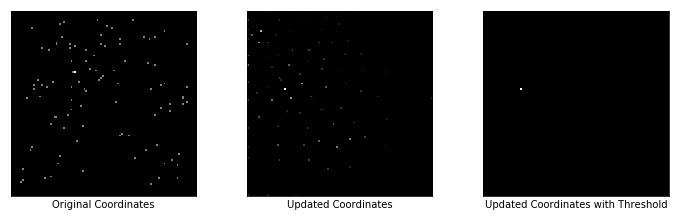

Epochs: 900, Session: 3
Reconstruction Loss: 0.0010482297511771321
Regularizer Loss: 209291.6875, Total Loss: 209291.6875
Encoder Loss: 1.2754732370376587
Max Similarity scores: 0.4250127077102661
Updated Coordinates: [[[0.         0.79427236]]]
Gradient global min:-0.005255717784166336, max:0.008395925164222717
Gradient encoder min:-0.4492354393005371, max:0.49543312191963196
Gradient learnable coords min:-2.629527443787083e-05, max:1.8946479031001218e-05



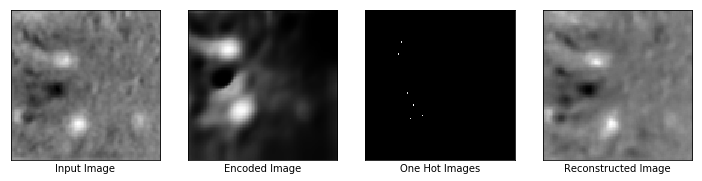

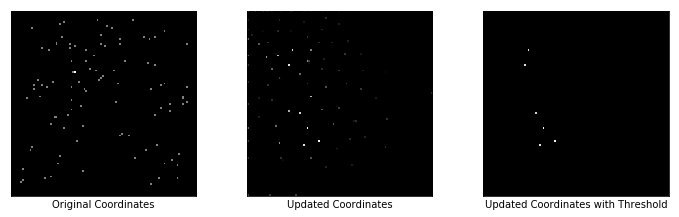

Epochs: 900, Session: 4
Reconstruction Loss: 0.0009418328991159797
Regularizer Loss: 197087.9375, Total Loss: 197087.9375
Encoder Loss: 0.8530226945877075
Max Similarity scores: 0.41028597950935364
Updated Coordinates: [[[0.         0.79654956]]]
Gradient global min:-0.0009125721408054233, max:0.0004629921168088913
Gradient encoder min:-0.27799877524375916, max:0.32368677854537964
Gradient learnable coords min:-2.0939649402862415e-05, max:3.6498004192253575e-05



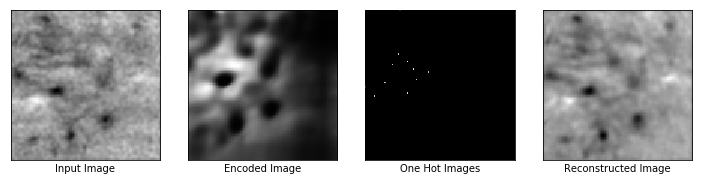

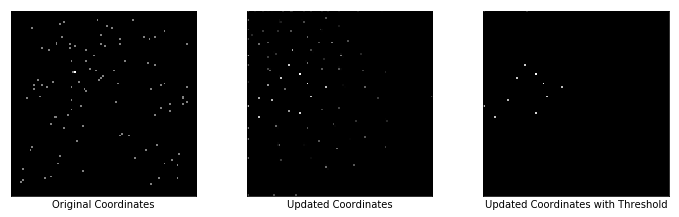

Epochs: 900, Session: 5
Reconstruction Loss: 0.0017315418226644397
Regularizer Loss: 220629.234375, Total Loss: 220629.234375
Encoder Loss: 1.7714043855667114
Max Similarity scores: 0.43360692262649536
Updated Coordinates: [[[0.        0.7958568]]]
Gradient global min:-0.0007006922969594598, max:0.00046954379649832845
Gradient encoder min:-0.7614126801490784, max:0.6731874346733093
Gradient learnable coords min:-5.10698100697482e-06, max:2.306509304617066e-05



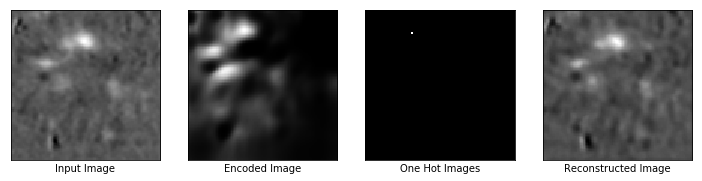

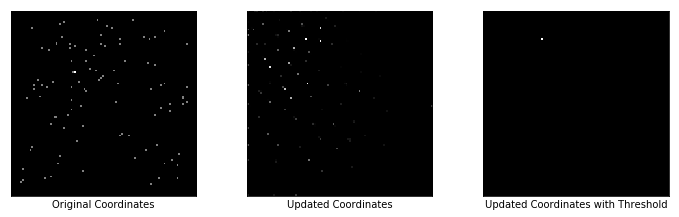

Epochs: 1000, Session: 0
Reconstruction Loss: 0.0006981068872846663
Regularizer Loss: 239119.21875, Total Loss: 239119.21875
Encoder Loss: 1.0500813722610474
Max Similarity scores: 0.3250185251235962
Updated Coordinates: [[[0.        0.8075475]]]
Gradient global min:-0.0005792616866528988, max:0.0003688788856379688
Gradient encoder min:-0.39744171500205994, max:0.473857045173645
Gradient learnable coords min:-1.3568860595114529e-05, max:1.6669089745846577e-05



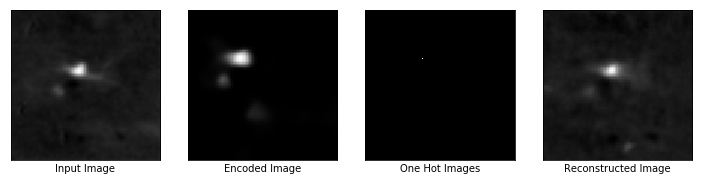

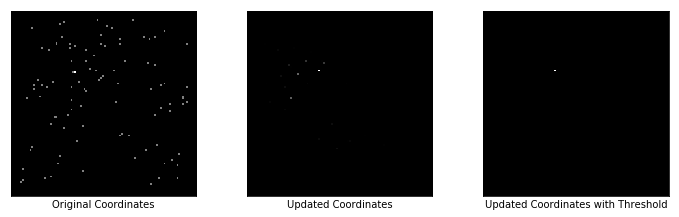

Epochs: 1000, Session: 1
Reconstruction Loss: 0.0007237833924591541
Regularizer Loss: 214041.40625, Total Loss: 214041.40625
Encoder Loss: 0.2139320820569992
Max Similarity scores: 0.41626983880996704
Updated Coordinates: [[[0.        0.8041434]]]
Gradient global min:-0.0004106268170289695, max:0.0004164377460256219
Gradient encoder min:-0.22316323220729828, max:0.11713261902332306
Gradient learnable coords min:-8.36380149848992e-06, max:1.7001946616801433e-05



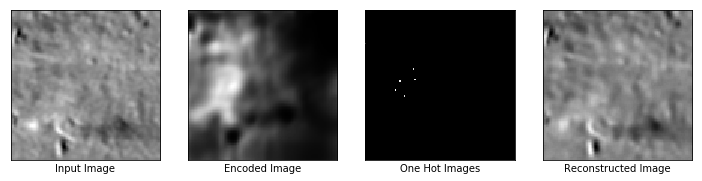

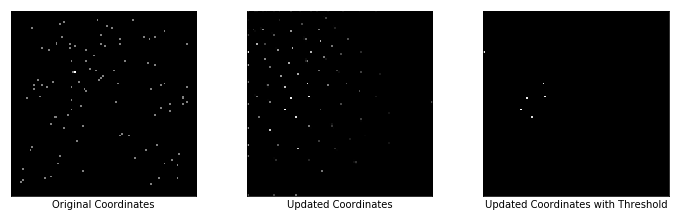

Epochs: 1000, Session: 2
Reconstruction Loss: 0.0019435554277151823
Regularizer Loss: 263495.5, Total Loss: 263495.5
Encoder Loss: 1.7473831176757812
Max Similarity scores: 0.3655337989330292
Updated Coordinates: [[[0.         0.78986096]]]
Gradient global min:-0.0034979258198291063, max:0.004468625411391258
Gradient encoder min:-0.764538586139679, max:0.6812043786048889
Gradient learnable coords min:-1.961999441846274e-05, max:5.0356386054772884e-05



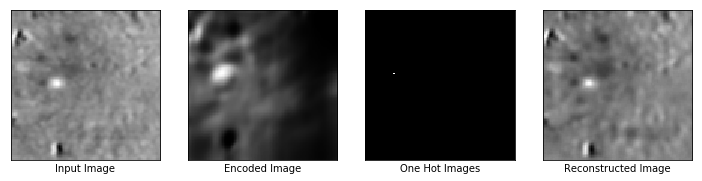

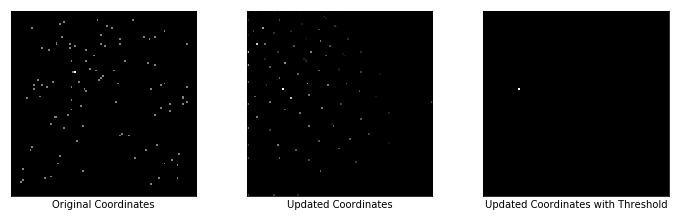

Epochs: 1000, Session: 3
Reconstruction Loss: 0.0021294739563018084
Regularizer Loss: 244790.234375, Total Loss: 244790.234375
Encoder Loss: 1.1496151685714722
Max Similarity scores: 0.39705583453178406
Updated Coordinates: [[[0.        0.7977808]]]
Gradient global min:-0.005640657152980566, max:0.0025022998452186584
Gradient encoder min:-0.4074208438396454, max:0.45645779371261597
Gradient learnable coords min:-4.342112151789479e-05, max:3.1246898288372904e-05



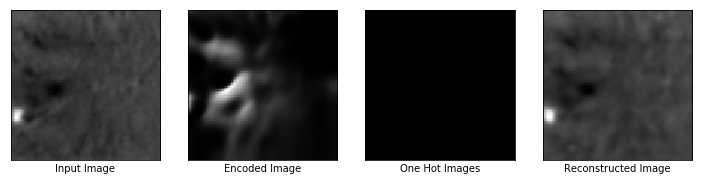

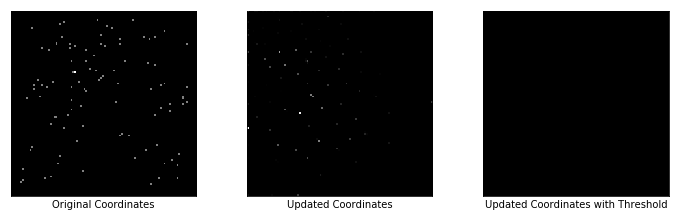

Epochs: 1000, Session: 4
Reconstruction Loss: 0.000824442773591727
Regularizer Loss: 231499.375, Total Loss: 231499.375
Encoder Loss: 0.8163084387779236
Max Similarity scores: 0.17683815956115723
Updated Coordinates: [[[0.         0.79880005]]]
Gradient global min:-0.00029466248815879226, max:0.0006599290063604712
Gradient encoder min:-0.25835981965065, max:0.3151695728302002
Gradient learnable coords min:-5.744552254327573e-06, max:1.5094074115040712e-05



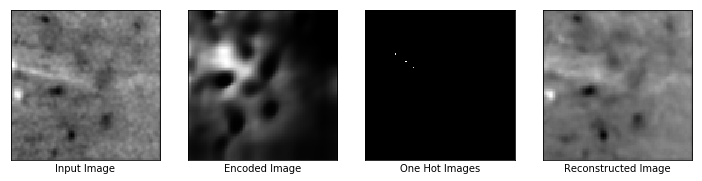

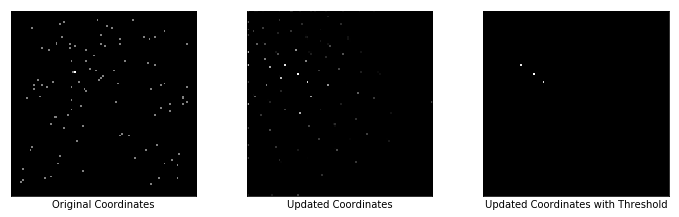

Epochs: 1000, Session: 5
Reconstruction Loss: 0.0016192926559597254
Regularizer Loss: 256527.9375, Total Loss: 256527.9375
Encoder Loss: 1.57405424118042
Max Similarity scores: 0.36515453457832336
Updated Coordinates: [[[0.        0.7969147]]]
Gradient global min:-0.003286033635959029, max:0.004253319930285215
Gradient encoder min:-0.6726510524749756, max:0.609908401966095
Gradient learnable coords min:-5.2541996410582215e-05, max:2.8578113415278494e-05


In [12]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    sess = 0
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        #loss for each session
        loss_sess = [] #reconstruction loss
        reg_loss_sess = [] #regularizer loss
        enc_loss_sess = [] #ecnoder loss
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
#                 encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
#                 reconstruction_last_sess.append(reconstruction)
        
        #append all sessions for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
#             encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
#             reconstruction_last_list.append(reconstruction_last_sess)


        if epochs%100==0:
            rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
            img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
            img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
            plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
            plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
            #print for each session in the epochs 
            #note for loss indices
            #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
            print("Epochs: {}, Session: {}".format(epochs, sess))
            print("Reconstruction Loss: {}".format(loss[0].numpy()))
            print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
            print("Encoder Loss: {}".format(loss[1].numpy()))
            print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
            print("Updated Coordinates: {}".format(updated_coords[0]))
            print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
            print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
            print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
            #append to list 
            encoded_imgs.append(encoder_output)
            input_imgs.append(batched_imgs)
            coords_list.append(updated_coords)
            reconstructed_imgs.append(reconstruction)
            one_hot_imgs_list.append(one_hot_imgs)
            similarity_list.append(similarity_score)
        
        sess+=1
        #append all losses for each session
        loss_sess.append(loss[0])
        reg_loss_sess.append(loss[1])
        enc_loss_sess.append(loss[-1])
    #loss is append for each epochs
    loss_list_global.append(np.mean(np.array(loss_sess)))
    loss_list_encoded_one_hot.append(np.mean(np.array(reg_loss_sess)))
    regulariser_loss_list.append(np.mean(np.array(enc_loss_sess)))
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
store_name = [d.split(".")[0] for d in sorted(os.listdir(ds_dir))]
#intended save path 
int_save_path = path_desktop+'npy/{}/sim_one_{}'.format(ver, ver)
#create new file to store sim score and one hot images for last frames
if not os.path.exists(int_save_path):
    os.makedirs(int_save_path)

#save sim scores for every session in last epochs 
similarity_score_last_list = utils.concat_batch(similarity_score_last_list) #(sess, frames, n_neurons)
for idx, stack in enumerate(similarity_score_last_list):
    np.save(int_save_path+'/sim_last_{}_{}.npy'.format(store_name[idx], ver), np.array(stack))

In [16]:
#save one hot imgs for last epochs 
for idx,stack in enumerate(one_hot_imgs_last_list):
    tensor = tf.convert_to_tensor(stack, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
    np.save(int_save_path+'/one_last_{}_{}.npy'.format(store_name[idx], ver), np.array(tensor))

In [38]:
# #save info for every frames in last epochs
# save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
# save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

# for names, items in zip(save_names_last, save_list_last):
#     aggregate_tensor = utils.concat_batch(items)
#     np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [47]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [ ]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [19]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [20]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

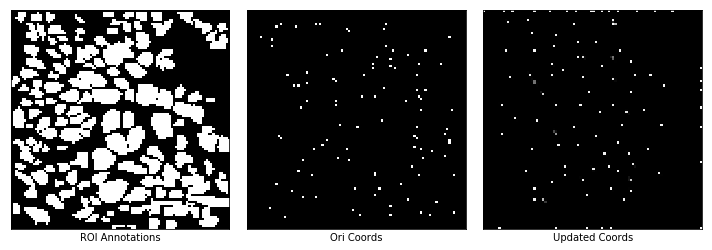

In [21]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  108


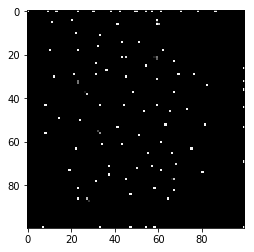

In [22]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

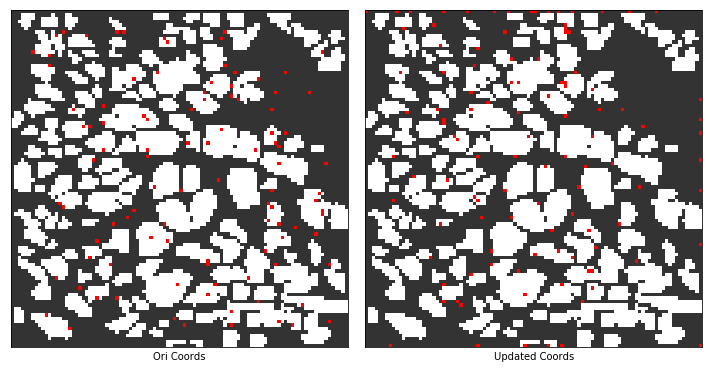

In [23]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [25]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

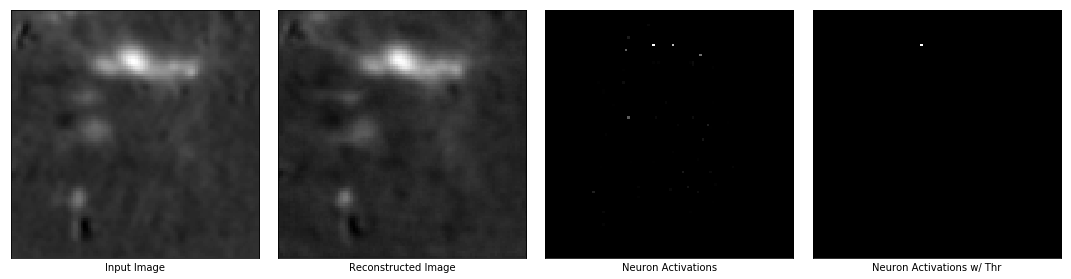

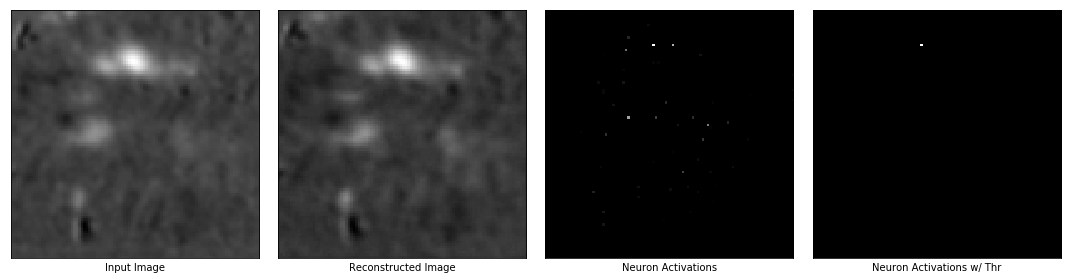

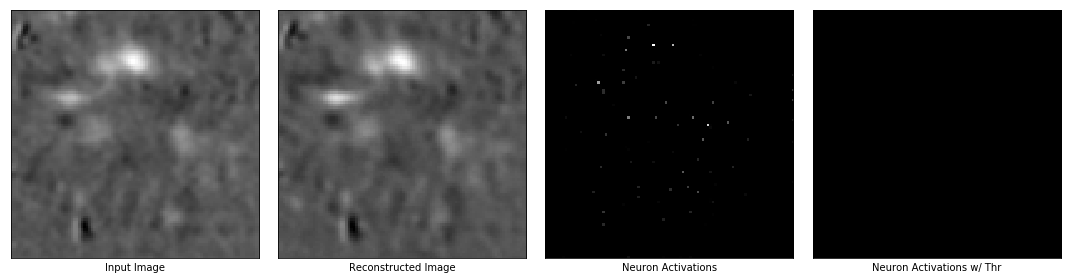

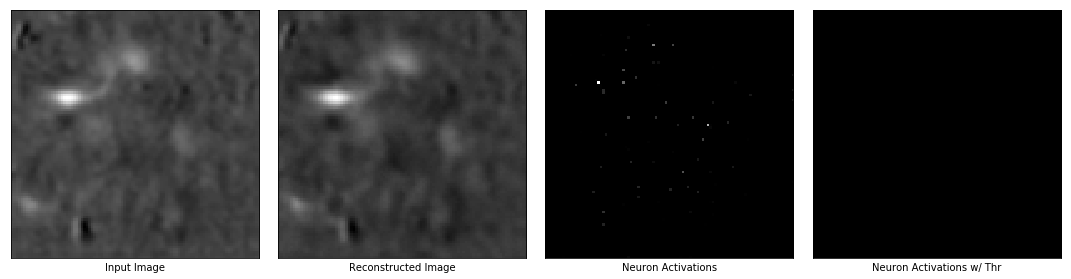

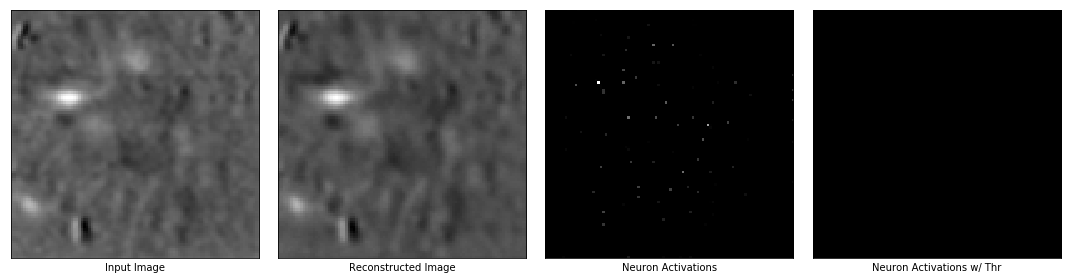

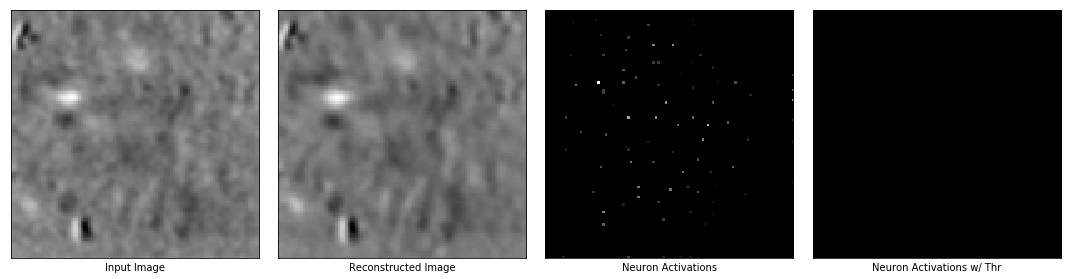

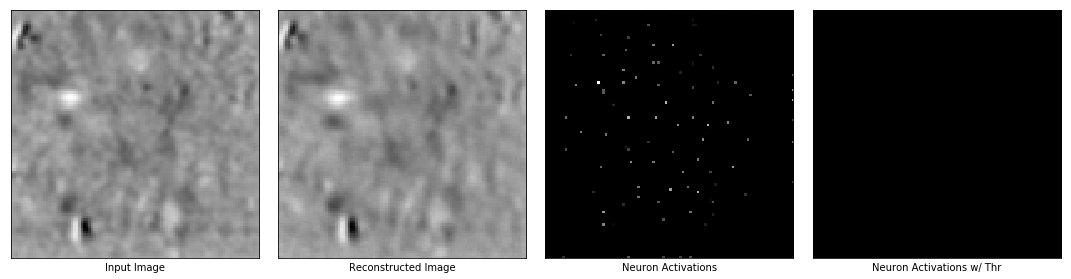

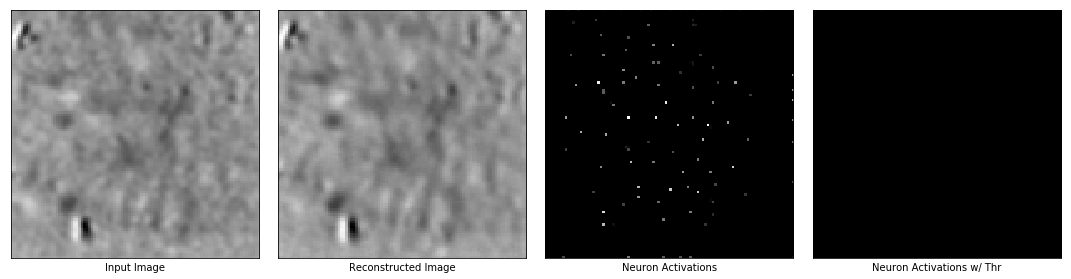

In [26]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

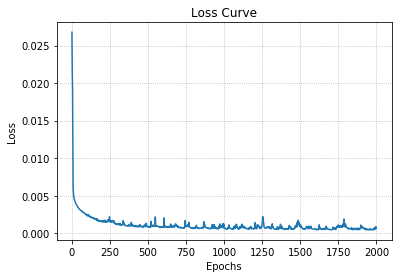

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [28]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


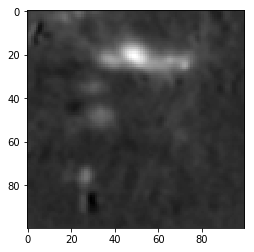

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


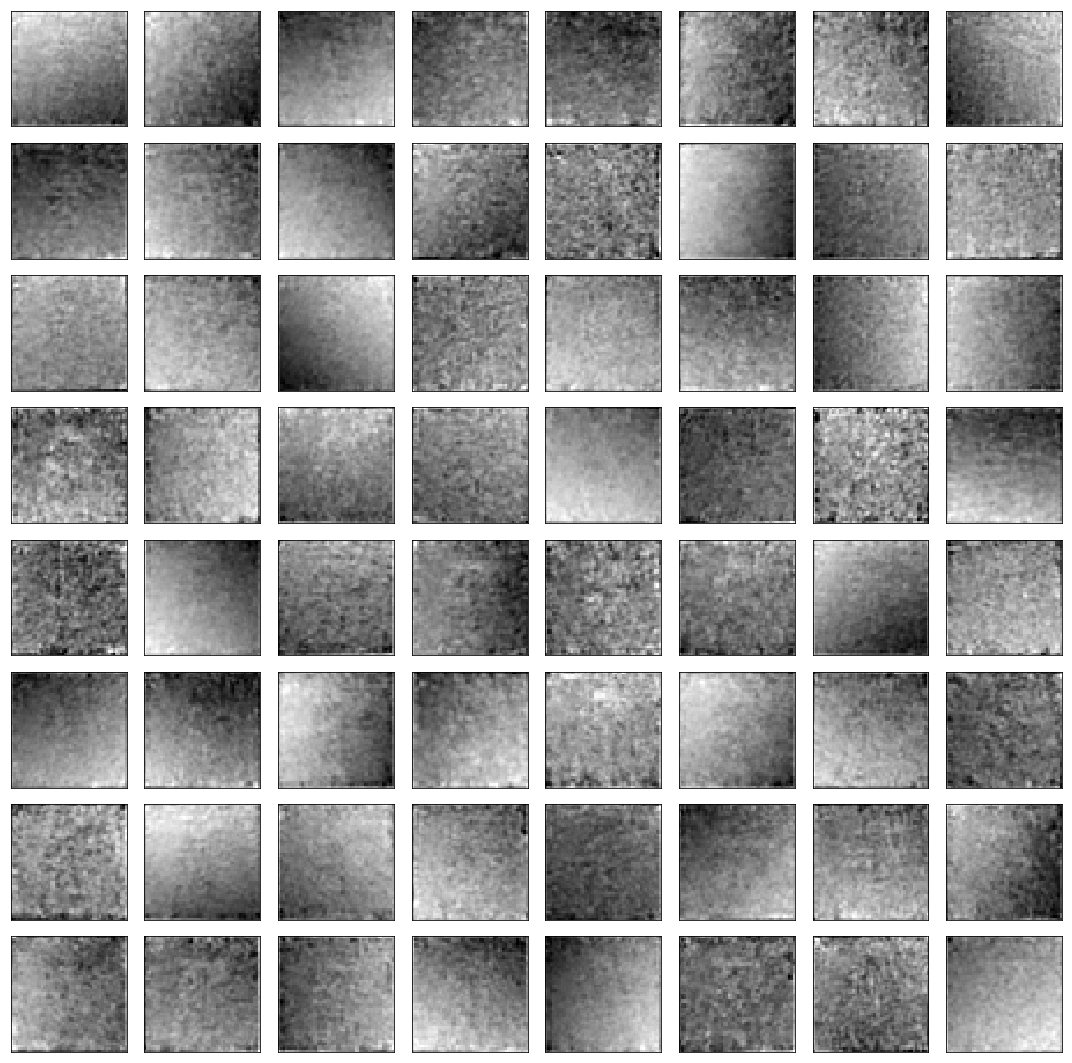

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


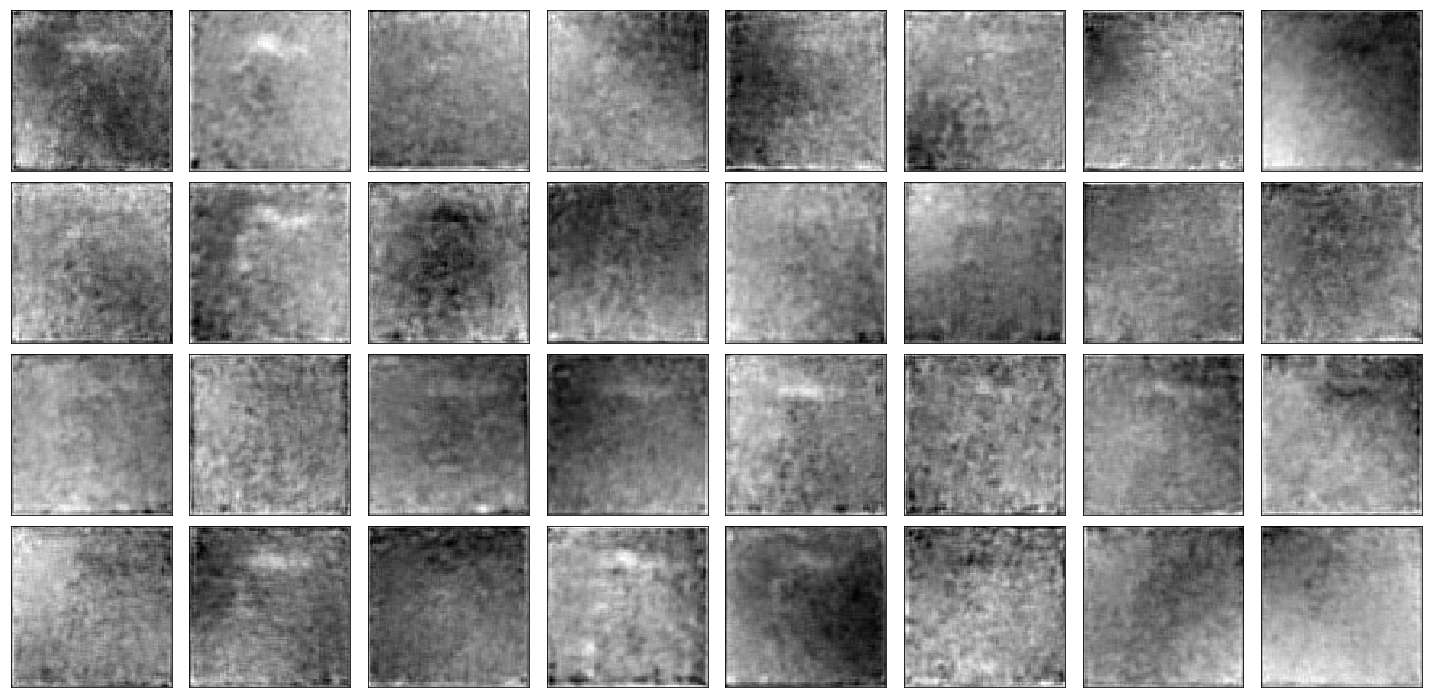

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

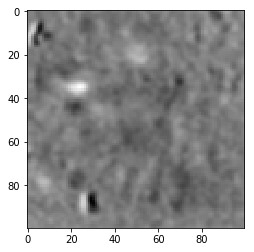

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


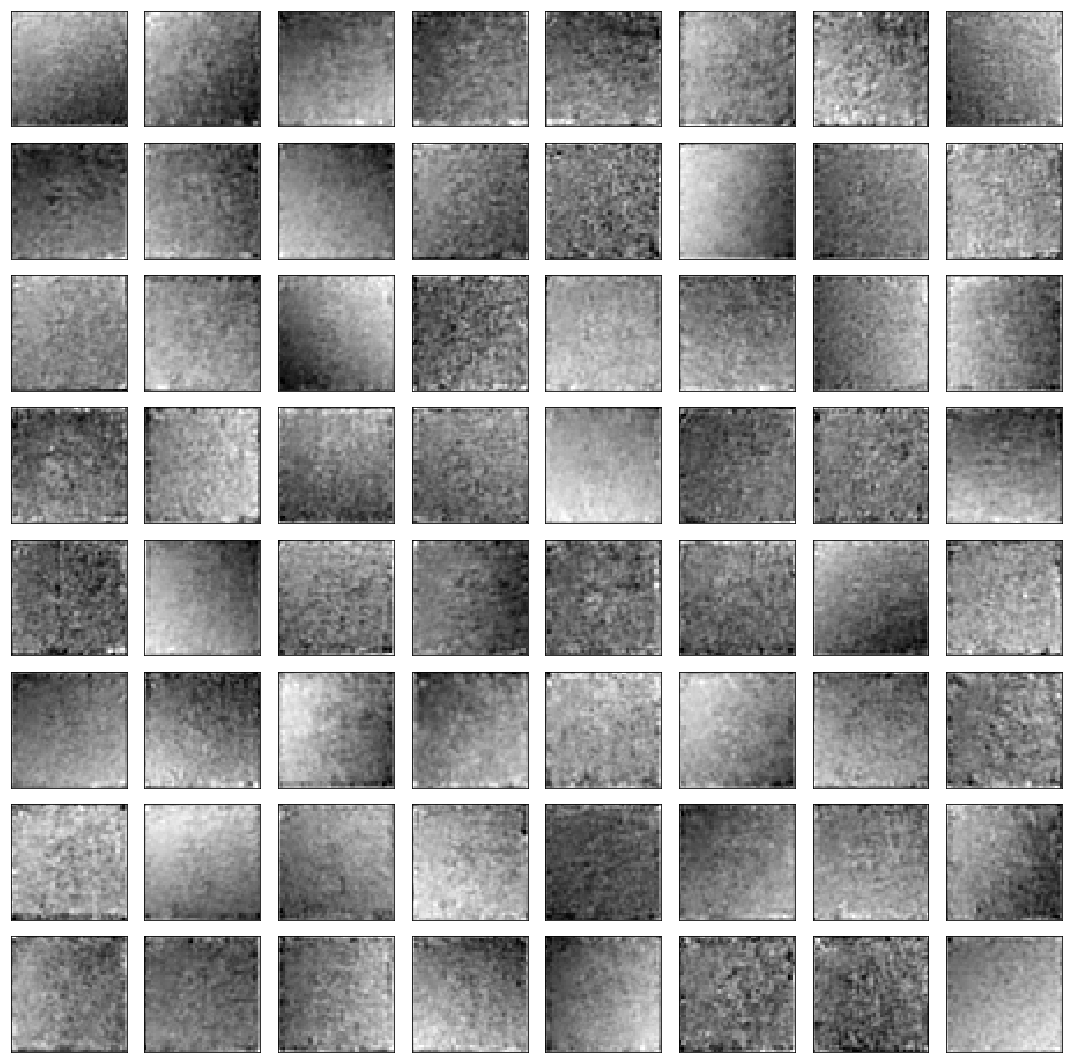

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


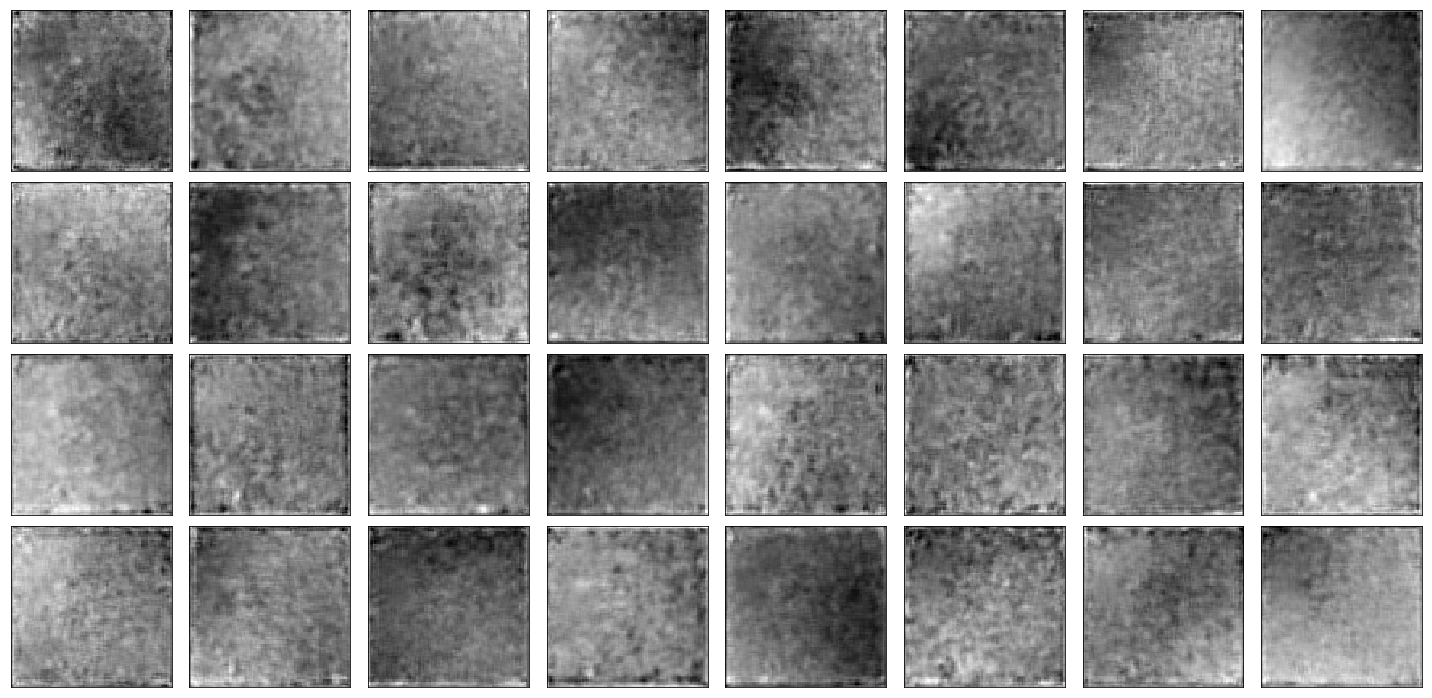

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

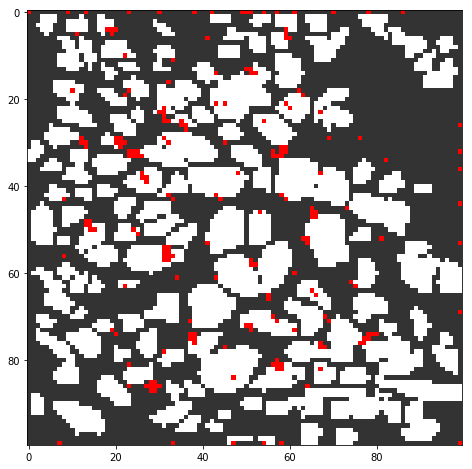

In [47]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

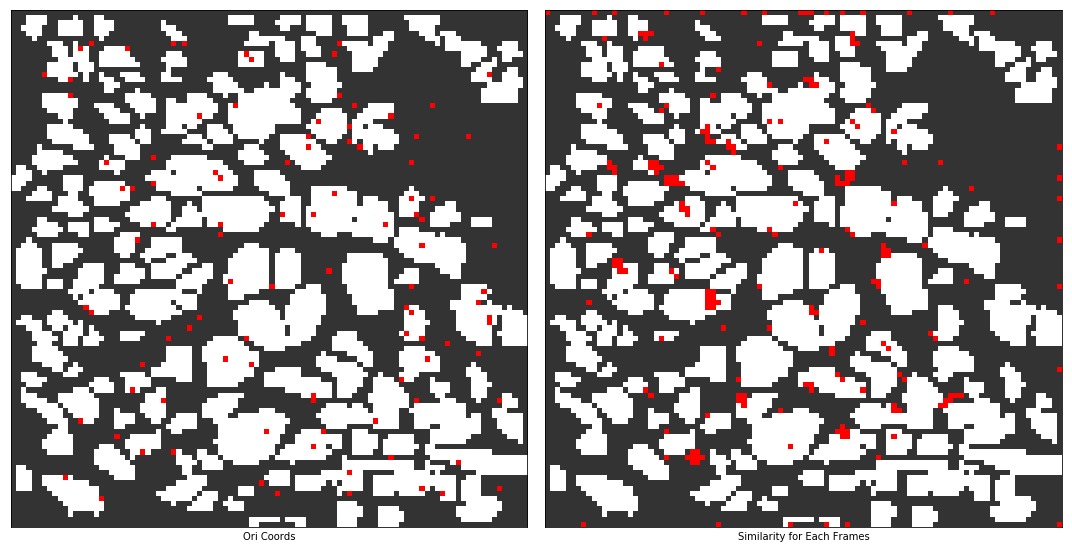

Counts:  201


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)